# Homework 1
In this homework, we will have you train some convolutional neural networks! We will start with a small dataset, and then work our way up to ImageNet!

For this homework we will train a classifier for Tiny Imagenet which you can read about here https://tiny-imagenet.herokuapp.com/ but don't bother downloading it just yet.

A note on file paths: Last homework, we used the homework1 folder. That was a mistake as it was technically homework 0. You may want to rename the folder from last time to homework0 before you begin.

# Part 0: Initial Setup
You should recognize this code from last time.


In [1]:
# This is code to download and install pytorch
import os
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())

    100% |████████████████████████████████| 483.0MB 44.9MB/s 
tcmalloc: large alloc 1073750016 bytes == 0x575be000 @  0x7fec410f52a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 61kB 2.6MB/s 
    100% |████████████████████████████████| 2.0MB 3.3MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
Version 0.4.1
CUDA enabled: True


In [2]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
'My Drive'


# Part 1: Upload the Dataset
Run this code to navigate to the BASE_PATH directory and upload the homework1.tar file inside the BASE_PATH, then extract it.

Have a look at pt_util. We moved some of the useful functions out of the python notebook to make it less cluttered, and added a few more useful functions.

I made the BASE_PATH and DATA_PATH variables so you don't have to copy the same strings all over the place if you want to move the locations of the files around.


In [3]:
BASE_PATH = '/gdrive/My Drive/colab_files/homework1/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = BASE_PATH + 'tiny_imagenet/'

!pwd
!ls
os.chdir(BASE_PATH)
if not os.path.exists(DATA_PATH + 'train.h5'):
    !wget http://pjreddie.com/media/files/homework1.tar
    !tar -xvf homework1.tar
    !rm homework1.tar
os.chdir('/content')

/content
sample_data


In [0]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
import h5py
import sys
sys.path.append(BASE_PATH)
import pt_util
from torch.autograd import Variable
import cv2

# Part 2: Defining the Network
We're giving you no instructions on this part. Welcome to deep learning research! See if you can get above 40% accuracy. You probably want to use the Cross Entropy error again, but who knows, maybe you can find a better loss function. We will give you a few hints of things to try. Have a look at https://github.com/pytorch/examples/blob/master/mnist/main.py for a basic neural network implementation.


- Activation functions other than ReLU
- Batch Norm
- Dropout
- Residual connections

Additionally, the current saving function always saves the latest results. You may want to modify it to only save the results if they have the highest test accuracy. Please make this modification.



In [0]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, device):
        super(Block, self).__init__()
        self.device = device
        #self.conv4 = nn.Conv2d(in_channels, out_channels, kernel_size=7, stride=1, padding=3)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.lrelu = nn.LeakyReLU()
        self.convweight = torch.autograd.Variable(torch.randn(3).to(device), requires_grad=True)
        self.bn = nn.BatchNorm2d(out_channels * 3)
    
    def forward(self, x):
        residual = x
        batch_size = x.shape[0]
        residual_channels = x.shape[1]
        
        
        # prob_weight = F.softmax(self.convweight)
        
        #conv4out = (self.lrelu(self.conv4(x)))
        conv3out = (self.lrelu(self.conv3(x))) # * prob_weight[2]
        conv2out = (self.lrelu(self.conv2(x))) # * prob_weight[1]
        conv1out = (self.lrelu(self.conv1(x))) # * prob_weight[0]
        
        convout = torch.cat([conv3out, conv2out, conv1out], dim=1)
        
#         print(convout.shape)

        convout = self.bn(self.lrelu(convout))
        
        out_channels = convout.shape[1]
#         print(out_channels, residual.shape)
        
#         if out_channels != residual_channels:
# #           print('temp', (batch_size, 
# #                    out_channels - residual_channels, 
# #                    convout.shape[2], 
# #                    convout.shape[3]
# #                   ))
#           output = torch.cat([
#               residual, 
#               torch.zeros(
#                   (batch_size, 
#                    out_channels - residual_channels, 
#                    convout.shape[2], 
#                    convout.shape[3]
#                   )
#               ).to(self.device)
#           ], dim=1)
#         else:
#           output = residual
        
#         output = output + convout
        return F.max_pool2d(convout, 2)


class TinyImagenetNet(nn.Module):
    def __init__(self, device):
        super(TinyImagenetNet, self).__init__()
        # TODO define the layers
        self.conv0 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv1 = Block(32, 12, device)
        self.conv2 = Block(36, 12, device)
        self.conv3 = Block(36, 24, device)
        self.conv4 = Block(72, 24, device)
        self.conv5 = Block(72, 72, device)
        self.conv3_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(864, 864) 
        self.fc2 = nn.Linear(864, 200) # 200 classes
        self.best_acc = 0

    def forward(self, x):
        # TODO define the forward pass
        batch = x.shape[0]
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = F.dropout(x, training=self.training)
        x = self.conv4(x)
        x = self.conv5(x)
        x = F.dropout(x, training=self.training)
        x = x.view(batch, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def loss(self, prediction, label, reduction='elementwise_mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        # TODO save the model if it is the best
        if self.best_acc < accuracy:
          self.best_acc = accuracy
          self.save_model(file_path, num_to_keep)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)


This time we are giving you the train and test functions, but feel free to modify them if you want. 

You may need to return some additional information for the logging portion of this assignment.


In [0]:
import time
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    total_loss = 0.0
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, label)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return total_loss / len(train_loader)
            

def test(model, device, test_loader, return_images=False, log_interval=None, return_acc=False):
    model.eval()
    test_loss = 0
    correct = 0

    correct_images = []
    correct_values = []

    error_images = []
    predicted_values = []
    gt_values = []
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss_on = model.loss(output, label, reduction='sum').item()
            test_loss += test_loss_on
            pred = output.max(1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            if return_images:
                if num_correct > 0:
                    correct_images.append(data[correct_mask, ...].data.cpu().numpy())
                    correct_value_data = label[correct_mask].data.cpu().numpy()[:, 0]
                    correct_values.append(correct_value_data)
                if num_correct < len(label):
                    error_data = data[~correct_mask, ...].data.cpu().numpy()
                    error_images.append(error_data)
                    predicted_value_data = pred[~correct_mask].data.cpu().numpy()
                    predicted_values.append(predicted_value_data)
                    gt_value_data = label[~correct_mask].data.cpu().numpy()[:, 0]
                    gt_values.append(gt_value_data)
            if log_interval is not None and batch_idx % log_interval == 0:
                print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    time.ctime(time.time()),
                    batch_idx * len(data), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader), test_loss_on))
    if return_images:
        correct_images = np.concatenate(correct_images, axis=0)
        error_images = np.concatenate(error_images, axis=0)
        predicted_values = np.concatenate(predicted_values, axis=0)
        correct_values = np.concatenate(correct_values, axis=0)
        gt_values = np.concatenate(gt_values, axis=0)

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))
    if return_images:
        return test_loss, correct_images, correct_values, error_images, predicted_values, gt_values
    if return_acc:
      return test_accuracy, test_loss

# PART 3: Loading Data
PyTorch has a nice interface for dealing with a variety of data. You can read a good tutorial here https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
Your friendly neighborhood TAs have made it even easier by preprocessing the data into a nice format. The data you uploaded is stored using hdf5 files which can be acecces a lot like Numpy arrays using the h5py package. In each of the files, there is a "dataset" called 'images', and one called 'labels'. Read more about h5py here http://docs.h5py.org/en/latest/quick.html

Speed hint: With small datasets, it is almost always a good idea to cache the data to disk rather than continually read from files.


In [0]:

# Data loader
class H5Dataset(torch.utils.data.Dataset):
    def __init__(self, h5_file, transform=None):
        # TODO Implement data loading.
        self.f = h5py.File(h5_file, 'r')
        self.dset = self.f['images'][:]
        self.labels = self.f['labels'][:]
        print(self.dset.shape)
        print(self.labels.shape)
        self.transform = transform

    def __len__(self):
        # TODO Implement the length function
        return len(self.dset)

    def __getitem__(self, idx):
        # TODO implement the getitem function
        # You should return a tuple of:
        #    a torch tensor containing single image in CxHxW format and
        #    the label as a single tensor scalar.
        data = self.dset[idx]
        label = self.labels[idx]
        if self.transform:
            data = self.transform(data)
        data = torch.Tensor(data)
        label = torch.Tensor(label).long()
        return (data, label)

# Part 4: Dataset Augmentation
In the MNIST assignment, we didn't do any data augmentation because MNIST is kind of easy.

In this assignment, you may find that data augmentation helps you a lot (or possibly hurts your performance).

You can find a bunch preimplemented here https://pytorch.org/docs/stable/torchvision/transforms.html and you can also do your own as seen in the tutorial from part 3.

Play around with various data augmentations we will suggest some.

- ToPILImage - This one is useful for a lot of the built in transforms which expect PIL images. 
- RandomHorizontalFlip
- RandomResizedCrop
- ColorJitter
- RandomRotation
- Normalize
- Adding various types of noise
- ToTensor - PyTorch expects the output from the dataset to be a tensor in CxHxW format.


Note: You should be careful about which of these you apply to the test data. You usually don't want to apply noise to the test data, but you do want to normalize it in the same way for example.


In [8]:
train_transforms = transforms.Compose([
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.ToTensor()
])

data_train = H5Dataset(DATA_PATH + 'train.h5', transform=train_transforms)
data_test = H5Dataset(DATA_PATH + 'val.h5', transform=test_transforms)

(100000, 64, 64, 3)
(100000, 1)
(10000, 64, 64, 3)
(10000, 1)


# Part 5: Training the network
Generally, it is useful to see how your training is going. Often people print their loss to make sure it goes down and their accuracy to make sure it goes up. But pictures are better than words. So for this part, you should record and plot the training loss, test loss, and test accuracy (and whatever else you want). 

We have created a very simple logging interface which essentially just saves and restores files via pickle in pt_util. Saving and restoring log data is important if you end your run early and want to continue where you left off rather than starting over.

We have also provided a plot function which can plot a single line graph. You can use it and plot each value independently, or change it to plot them all in one graph. 


__Important note: Do not forget to title your graphs and label your axes. Plots are meaningless without a way to read them.__

Second Note: It will be helpful for you when deciding what network structure, data augmentation, and such work to title the graphs accordingly so you remember.
Third Note: The default setup right now saves and restores the network weights from a single folder. When you modify network architectures, you may want to save the resulting files in different folders (with appropriate names).

We also provided a function for showing some results, because it's not satisfying to train a neural net, you also want to see what it can do! This can also be useful for figuring out what your network is doing well, and what it is failing at. This type of error analysis is very common when training neural networks.


Using device cuda
num cpus: 2

Test set: Average loss: 5.2986, Accuracy: 50/10000 (0%)



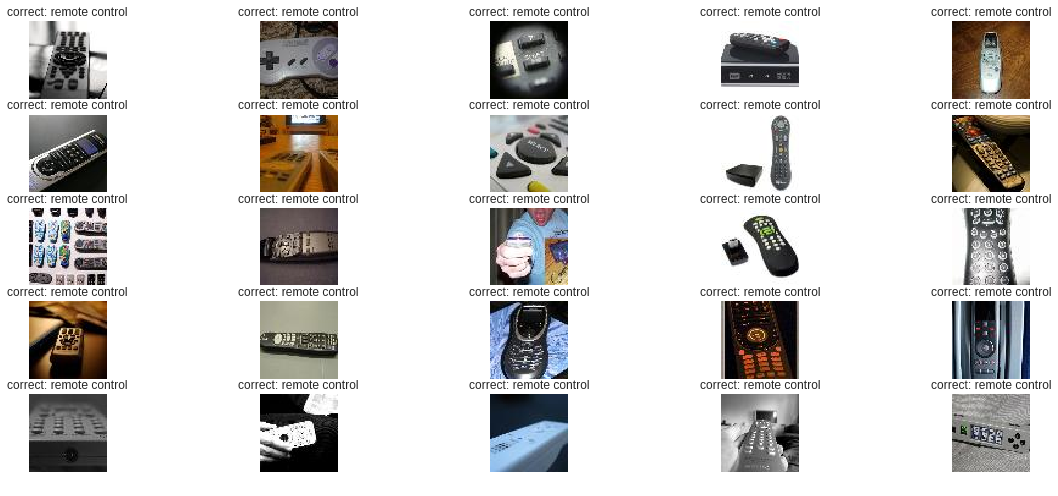

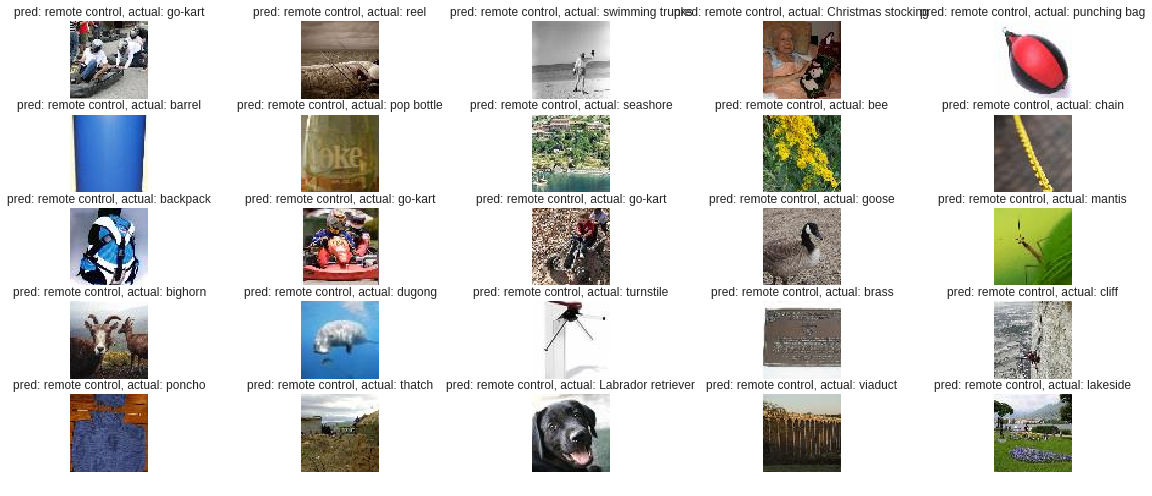

Wed Oct 31 21:40:58 2018 Train Epoch: 0 [0/100000 (0%)]	Loss: 5.328990
Wed Oct 31 21:41:29 2018 Train Epoch: 0 [25600/100000 (26%)]	Loss: 5.097258
Wed Oct 31 21:41:59 2018 Train Epoch: 0 [51200/100000 (51%)]	Loss: 4.857802
Wed Oct 31 21:42:30 2018 Train Epoch: 0 [76800/100000 (77%)]	Loss: 4.551260

Test set: Average loss: 4.4128, Accuracy: 765/10000 (8%)

Saved /gdrive/My Drive/colab_files/homework1/tiny_imagenet/test_no_residual/checkpoints/000.pt



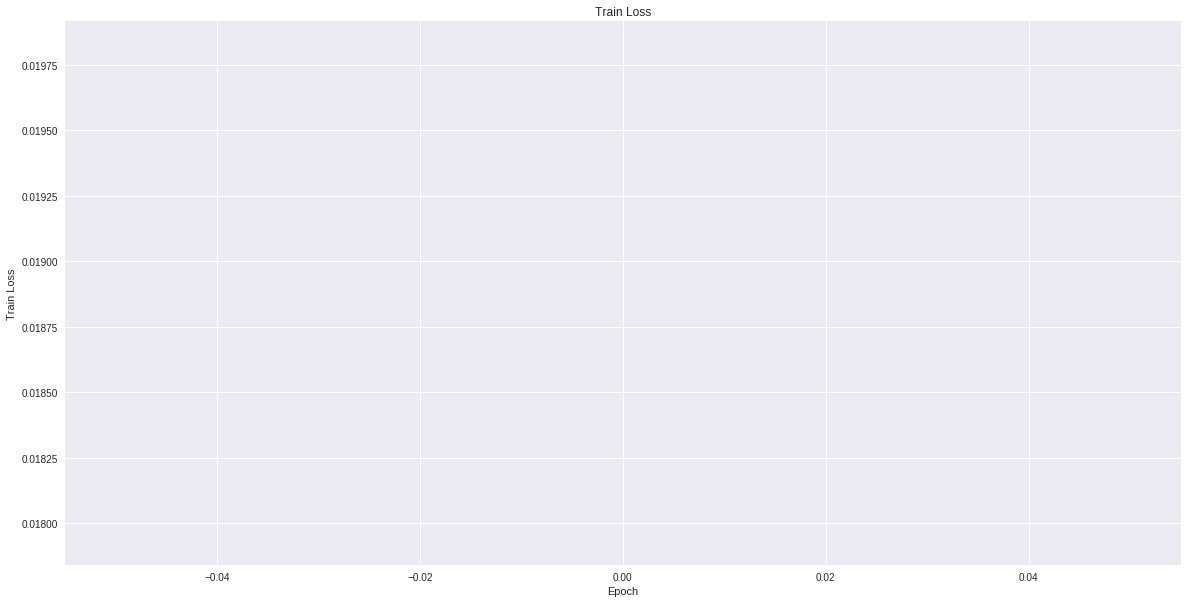

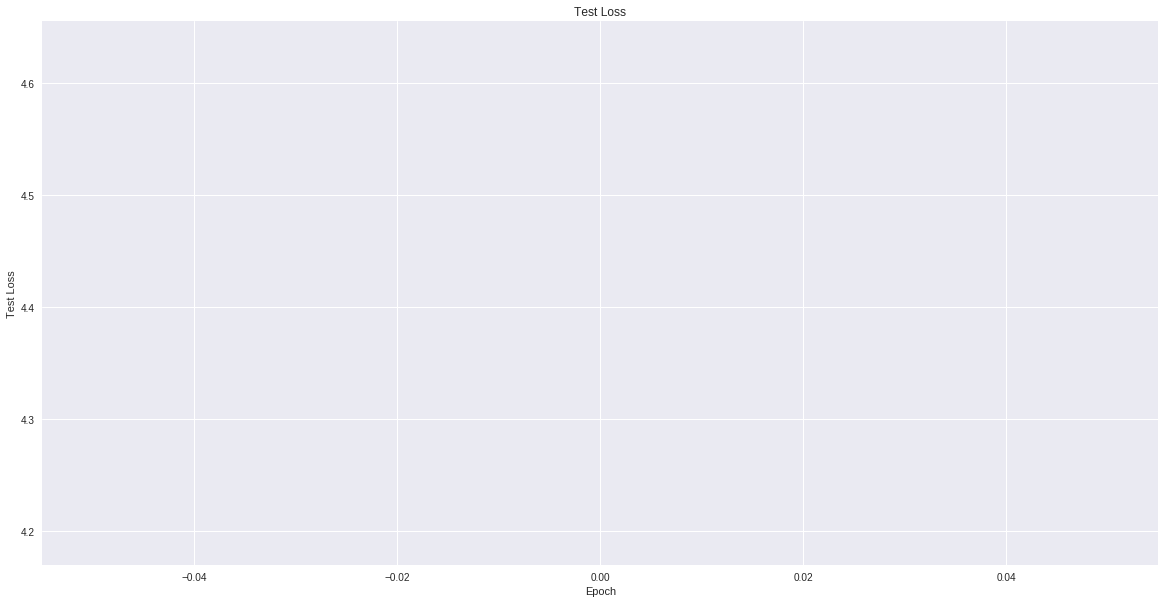

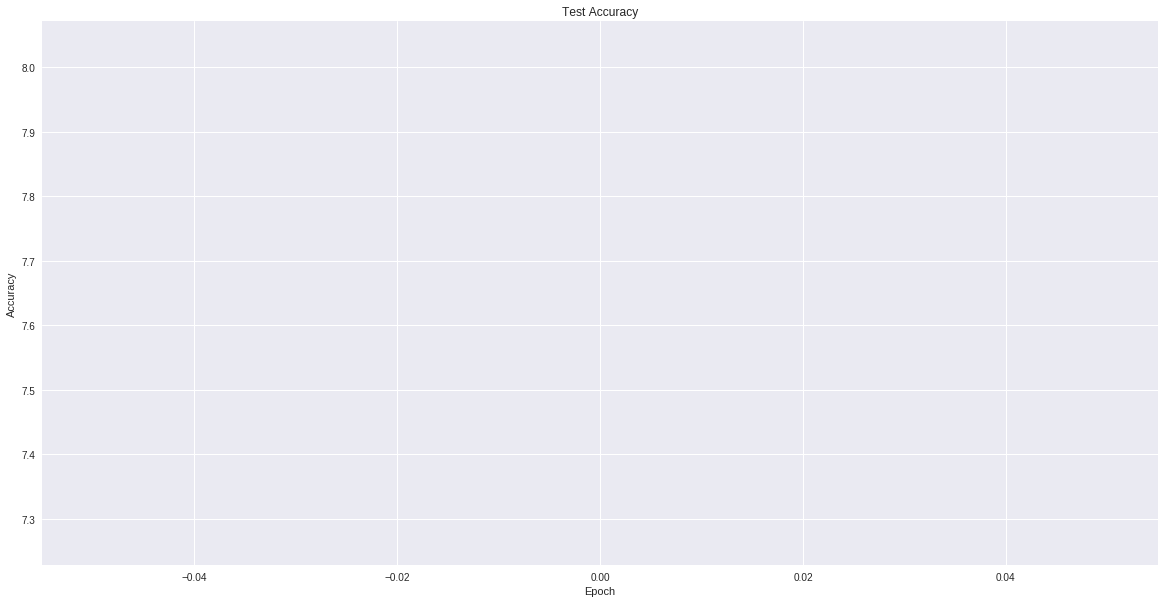

test accuracy:  7.65
Wed Oct 31 21:43:14 2018 Train Epoch: 1 [0/100000 (0%)]	Loss: 4.254572
Wed Oct 31 21:43:44 2018 Train Epoch: 1 [25600/100000 (26%)]	Loss: 4.178417
Wed Oct 31 21:44:15 2018 Train Epoch: 1 [51200/100000 (51%)]	Loss: 4.024852
Wed Oct 31 21:44:45 2018 Train Epoch: 1 [76800/100000 (77%)]	Loss: 3.940497

Test set: Average loss: 4.0200, Accuracy: 1424/10000 (14%)

Saved /gdrive/My Drive/colab_files/homework1/tiny_imagenet/test_no_residual/checkpoints/001.pt

test accuracy:  14.24
Wed Oct 31 21:45:29 2018 Train Epoch: 2 [0/100000 (0%)]	Loss: 3.584658
Wed Oct 31 21:46:00 2018 Train Epoch: 2 [25600/100000 (26%)]	Loss: 3.848842
Wed Oct 31 21:46:30 2018 Train Epoch: 2 [51200/100000 (51%)]	Loss: 3.670836
Wed Oct 31 21:47:01 2018 Train Epoch: 2 [76800/100000 (77%)]	Loss: 3.602370

Test set: Average loss: 3.7570, Accuracy: 1687/10000 (17%)

Saved /gdrive/My Drive/colab_files/homework1/tiny_imagenet/test_no_residual/checkpoints/002.pt

test accuracy:  16.87
Wed Oct 31 21:47:43 201

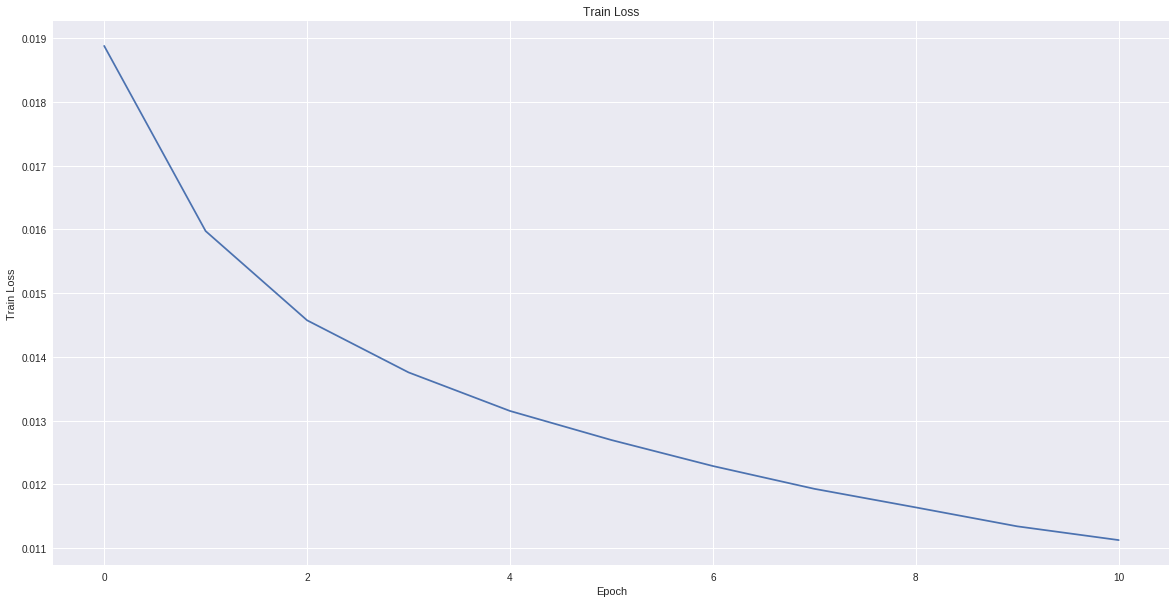

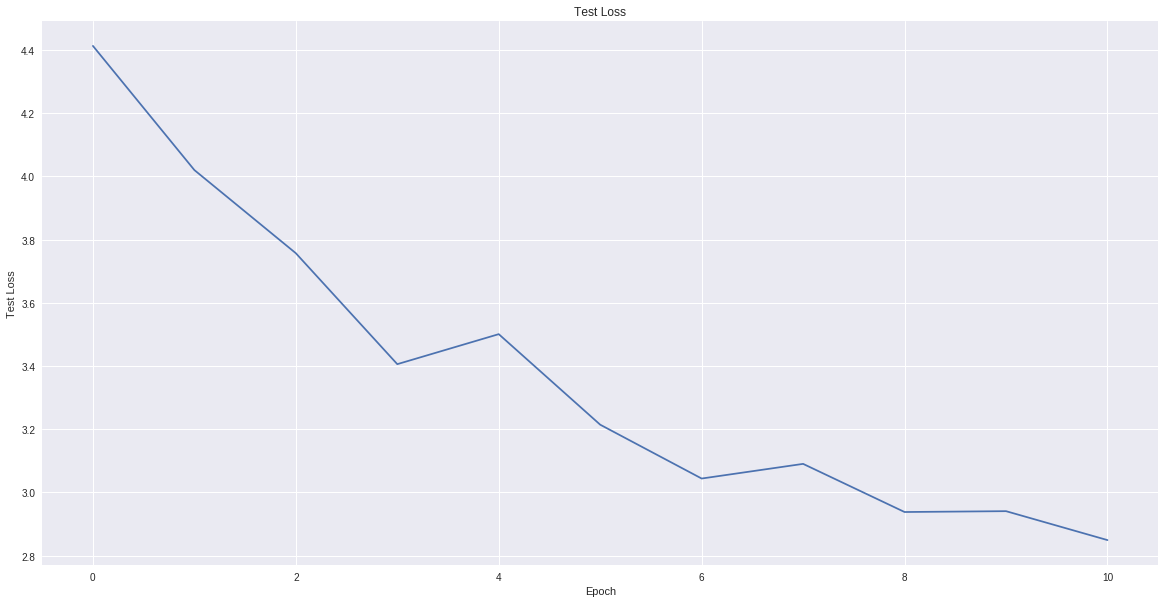

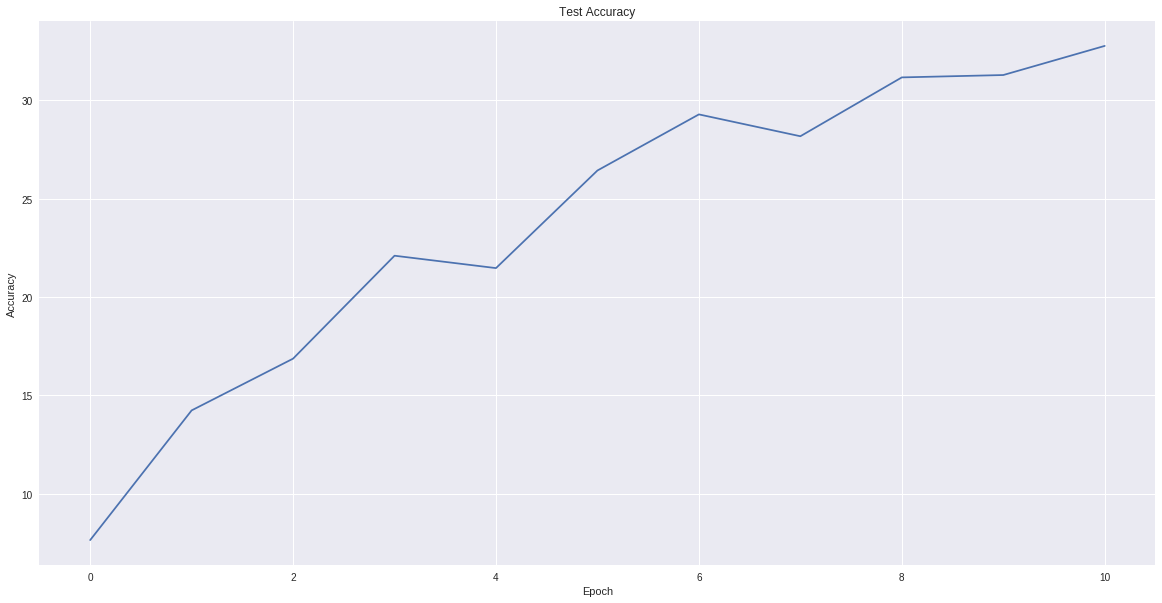

test accuracy:  32.76
Wed Oct 31 22:05:44 2018 Train Epoch: 11 [0/100000 (0%)]	Loss: 2.712474
Wed Oct 31 22:06:14 2018 Train Epoch: 11 [25600/100000 (26%)]	Loss: 2.952311
Wed Oct 31 22:06:45 2018 Train Epoch: 11 [51200/100000 (51%)]	Loss: 2.757596
Wed Oct 31 22:07:15 2018 Train Epoch: 11 [76800/100000 (77%)]	Loss: 2.576180

Test set: Average loss: 2.8220, Accuracy: 3355/10000 (34%)

Saved /gdrive/My Drive/colab_files/homework1/tiny_imagenet/test_no_residual/checkpoints/011.pt

test accuracy:  33.55
Wed Oct 31 22:07:58 2018 Train Epoch: 12 [0/100000 (0%)]	Loss: 2.686886
Wed Oct 31 22:08:29 2018 Train Epoch: 12 [25600/100000 (26%)]	Loss: 2.965715
Wed Oct 31 22:08:59 2018 Train Epoch: 12 [51200/100000 (51%)]	Loss: 2.718243
Wed Oct 31 22:09:30 2018 Train Epoch: 12 [76800/100000 (77%)]	Loss: 2.774335

Test set: Average loss: 2.8835, Accuracy: 3283/10000 (33%)

test accuracy:  32.83
Wed Oct 31 22:10:12 2018 Train Epoch: 13 [0/100000 (0%)]	Loss: 2.634027
Wed Oct 31 22:10:43 2018 Train Epoch: 

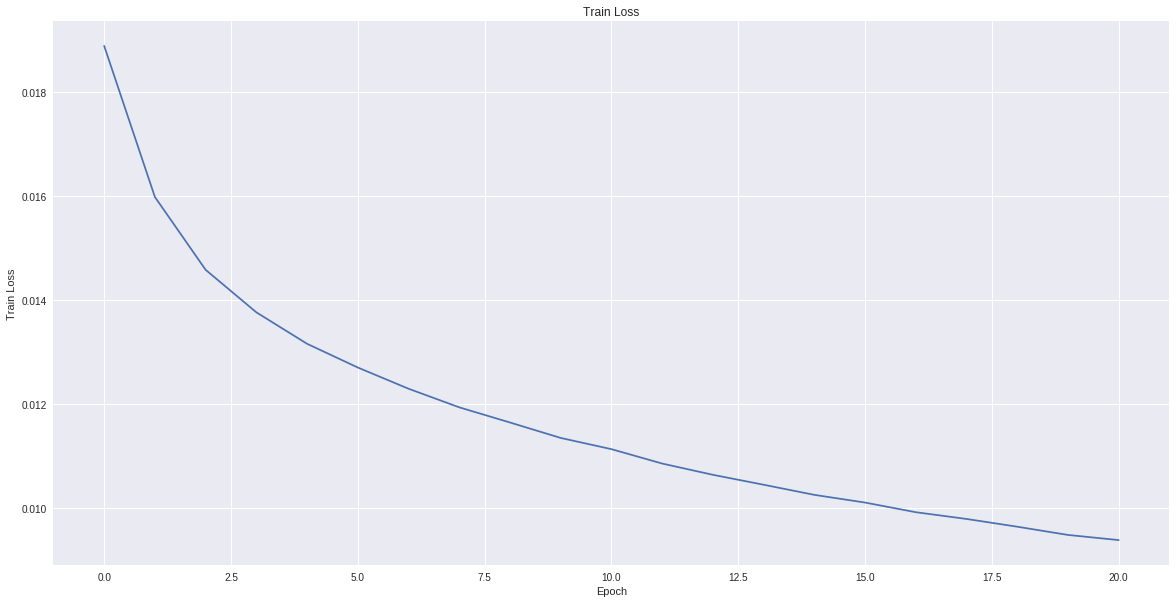

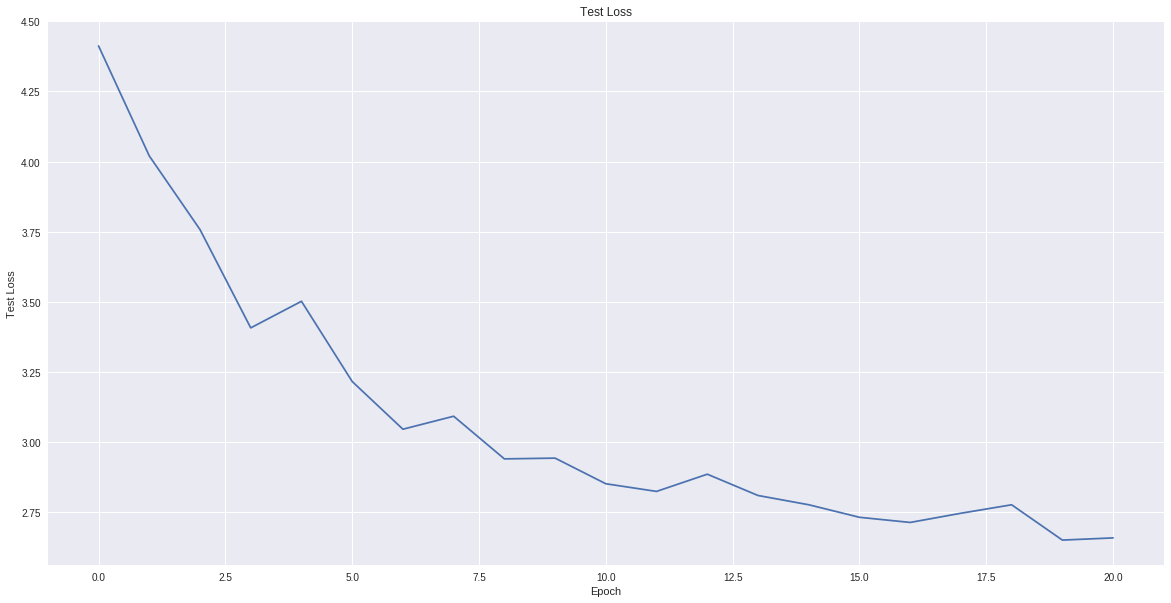

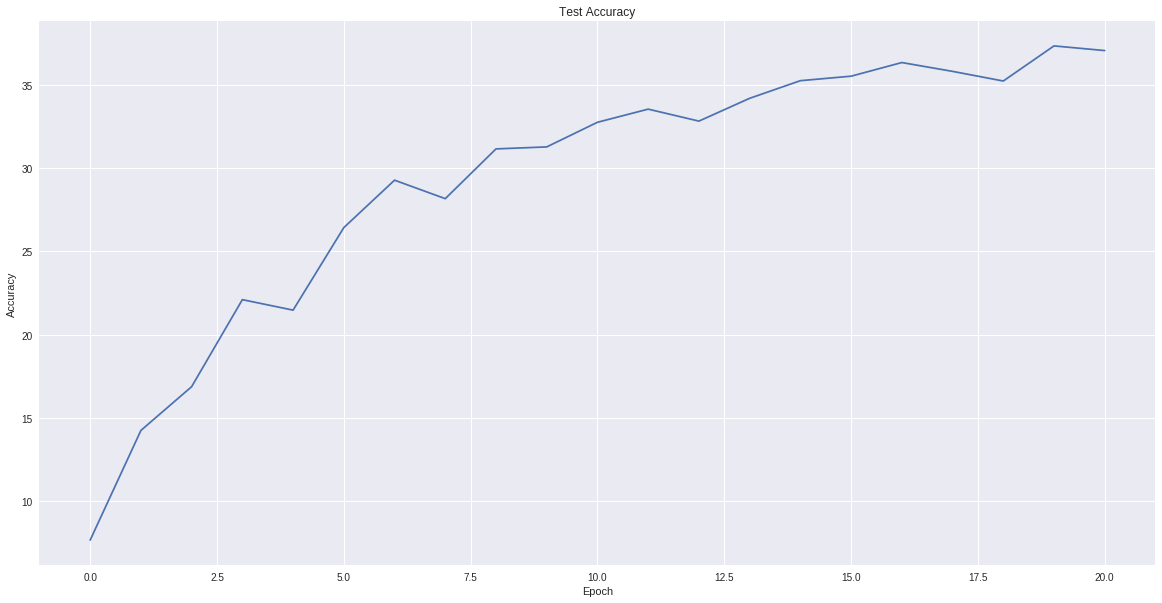

test accuracy:  37.07
Wed Oct 31 22:28:10 2018 Train Epoch: 21 [0/100000 (0%)]	Loss: 2.270100
Wed Oct 31 22:28:41 2018 Train Epoch: 21 [25600/100000 (26%)]	Loss: 2.304537
Wed Oct 31 22:29:12 2018 Train Epoch: 21 [51200/100000 (51%)]	Loss: 2.223859
Wed Oct 31 22:29:42 2018 Train Epoch: 21 [76800/100000 (77%)]	Loss: 2.433619

Test set: Average loss: 2.6228, Accuracy: 3822/10000 (38%)

Saved /gdrive/My Drive/colab_files/homework1/tiny_imagenet/test_no_residual/checkpoints/021.pt

test accuracy:  38.22
Wed Oct 31 22:30:26 2018 Train Epoch: 22 [0/100000 (0%)]	Loss: 2.466685
Wed Oct 31 22:30:56 2018 Train Epoch: 22 [25600/100000 (26%)]	Loss: 2.503944
Wed Oct 31 22:31:27 2018 Train Epoch: 22 [51200/100000 (51%)]	Loss: 2.418123
Wed Oct 31 22:31:57 2018 Train Epoch: 22 [76800/100000 (77%)]	Loss: 2.321911

Test set: Average loss: 2.6955, Accuracy: 3656/10000 (37%)

test accuracy:  36.56
Wed Oct 31 22:32:40 2018 Train Epoch: 23 [0/100000 (0%)]	Loss: 2.406677
Wed Oct 31 22:33:11 2018 Train Epoch: 

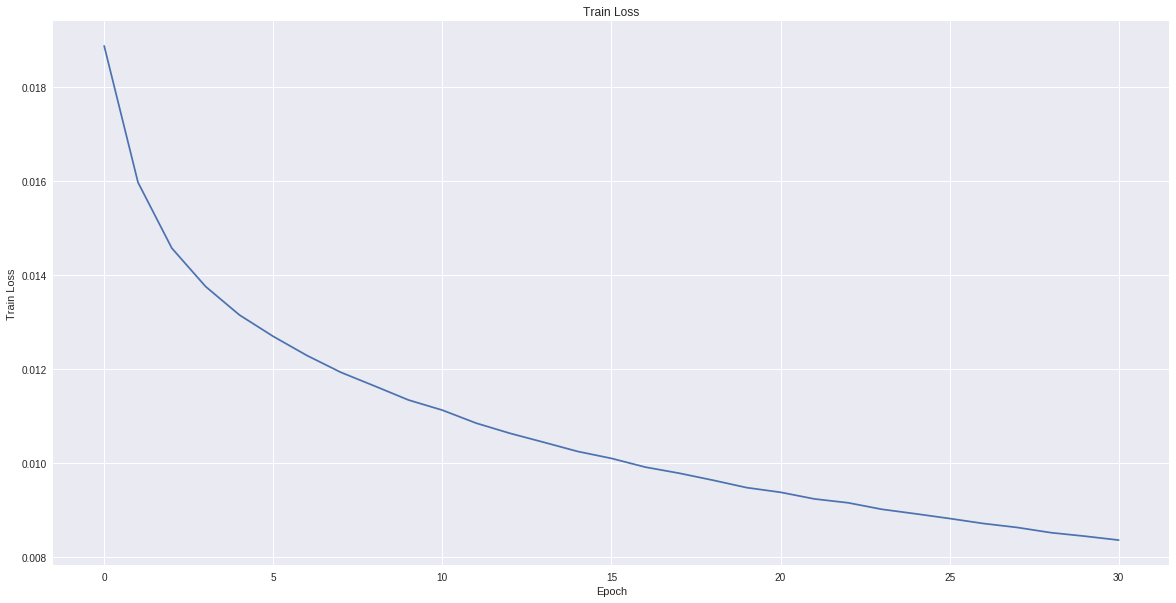

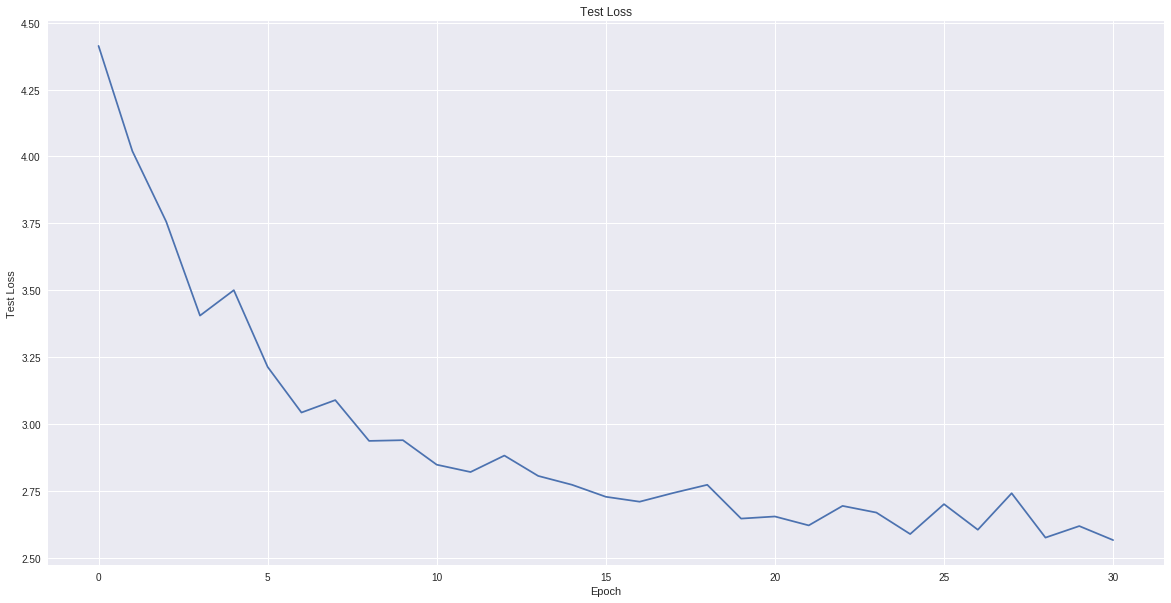

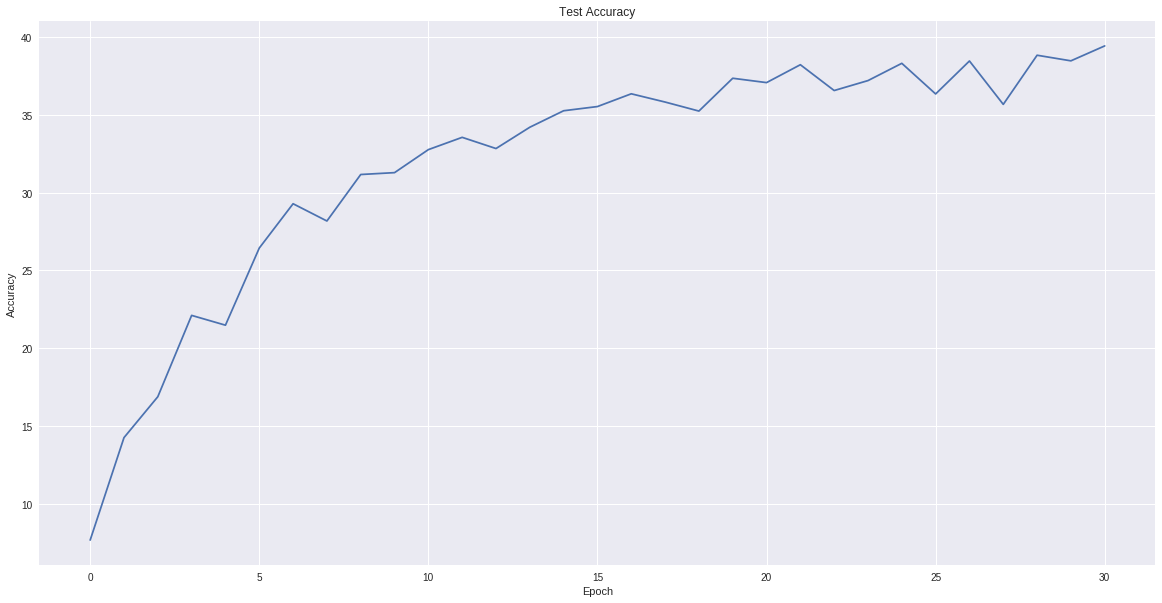

test accuracy:  39.43
Wed Oct 31 22:50:37 2018 Train Epoch: 31 [0/100000 (0%)]	Loss: 2.149262
Wed Oct 31 22:51:08 2018 Train Epoch: 31 [25600/100000 (26%)]	Loss: 2.091116
Wed Oct 31 22:51:38 2018 Train Epoch: 31 [51200/100000 (51%)]	Loss: 2.373597
Wed Oct 31 22:52:09 2018 Train Epoch: 31 [76800/100000 (77%)]	Loss: 2.150447

Test set: Average loss: 2.5579, Accuracy: 3937/10000 (39%)

test accuracy:  39.37
Wed Oct 31 22:52:53 2018 Train Epoch: 32 [0/100000 (0%)]	Loss: 1.863168
Wed Oct 31 22:53:24 2018 Train Epoch: 32 [25600/100000 (26%)]	Loss: 2.027128
Wed Oct 31 22:53:54 2018 Train Epoch: 32 [51200/100000 (51%)]	Loss: 2.261576
Wed Oct 31 22:54:25 2018 Train Epoch: 32 [76800/100000 (77%)]	Loss: 2.138819

Test set: Average loss: 2.6383, Accuracy: 3815/10000 (38%)

test accuracy:  38.15
Wed Oct 31 22:55:07 2018 Train Epoch: 33 [0/100000 (0%)]	Loss: 2.046825
Wed Oct 31 22:55:38 2018 Train Epoch: 33 [25600/100000 (26%)]	Loss: 2.025542
Wed Oct 31 22:56:08 2018 Train Epoch: 33 [51200/100000 (5

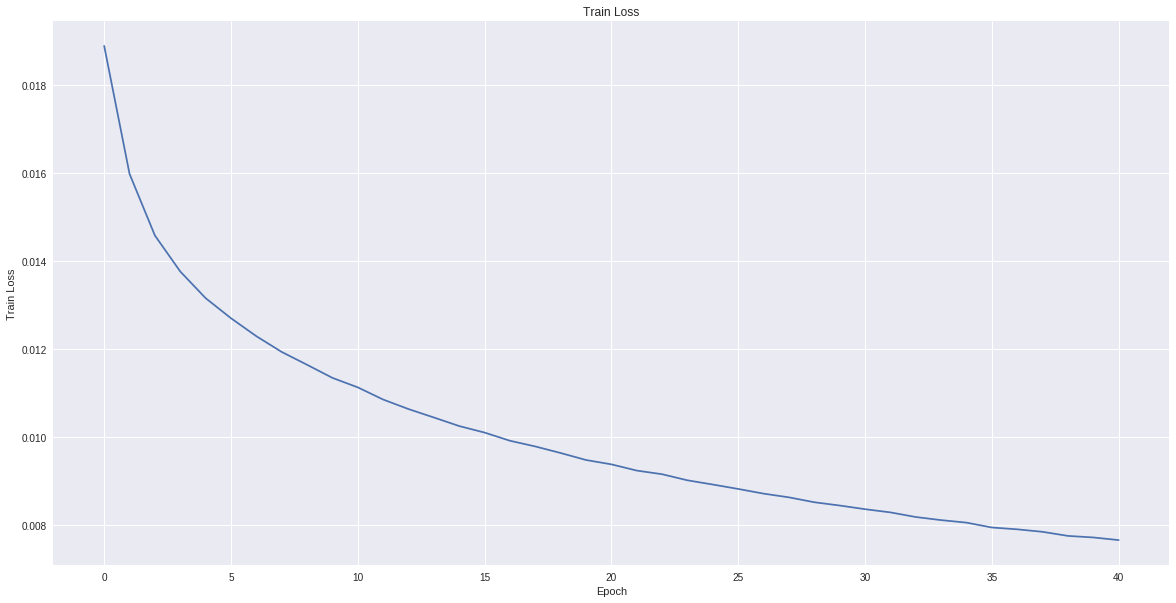

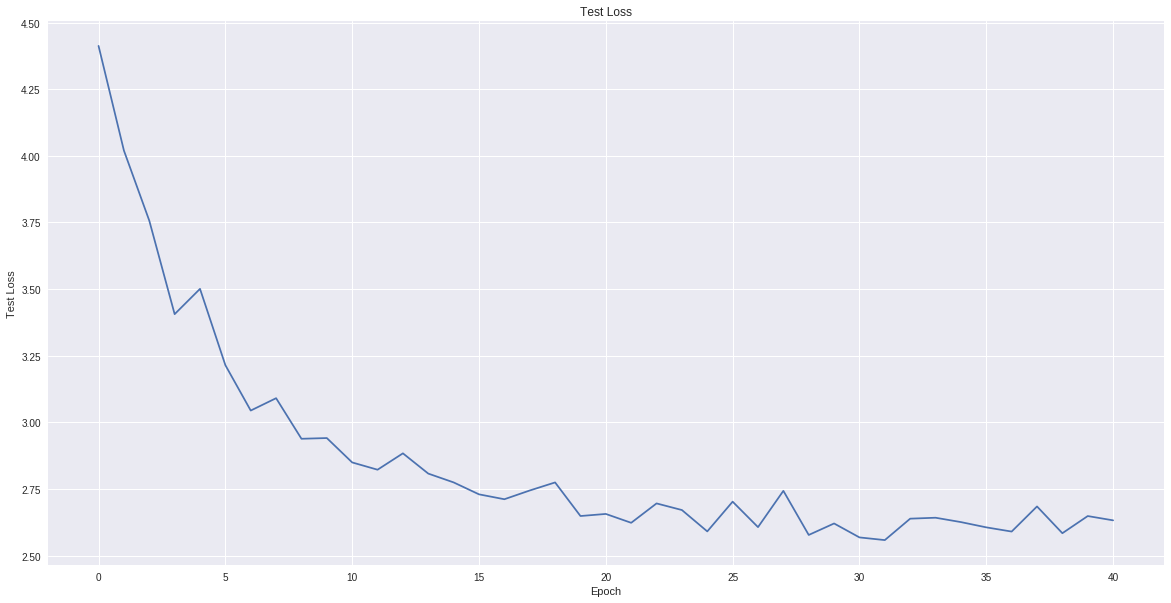

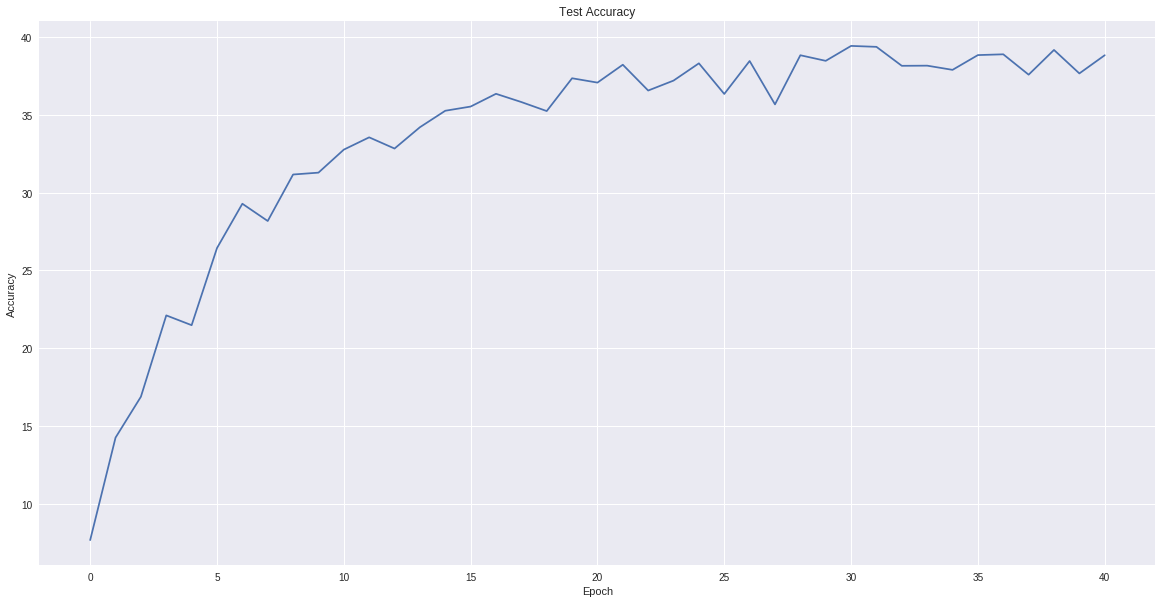

test accuracy:  38.83
Wed Oct 31 23:13:03 2018 Train Epoch: 41 [0/100000 (0%)]	Loss: 1.898884
Wed Oct 31 23:13:33 2018 Train Epoch: 41 [25600/100000 (26%)]	Loss: 1.750614
Wed Oct 31 23:14:04 2018 Train Epoch: 41 [51200/100000 (51%)]	Loss: 2.041293
Wed Oct 31 23:14:34 2018 Train Epoch: 41 [76800/100000 (77%)]	Loss: 2.047479

Test set: Average loss: 2.6108, Accuracy: 3910/10000 (39%)

test accuracy:  39.1
Wed Oct 31 23:15:16 2018 Train Epoch: 42 [0/100000 (0%)]	Loss: 1.875231
Wed Oct 31 23:15:47 2018 Train Epoch: 42 [25600/100000 (26%)]	Loss: 1.744927
Wed Oct 31 23:16:17 2018 Train Epoch: 42 [51200/100000 (51%)]	Loss: 2.050757
Wed Oct 31 23:16:48 2018 Train Epoch: 42 [76800/100000 (77%)]	Loss: 1.948845

Test set: Average loss: 2.6453, Accuracy: 3817/10000 (38%)

test accuracy:  38.17
Wed Oct 31 23:17:30 2018 Train Epoch: 43 [0/100000 (0%)]	Loss: 1.860317
Wed Oct 31 23:18:01 2018 Train Epoch: 43 [25600/100000 (26%)]	Loss: 1.903573
Wed Oct 31 23:18:31 2018 Train Epoch: 43 [51200/100000 (51

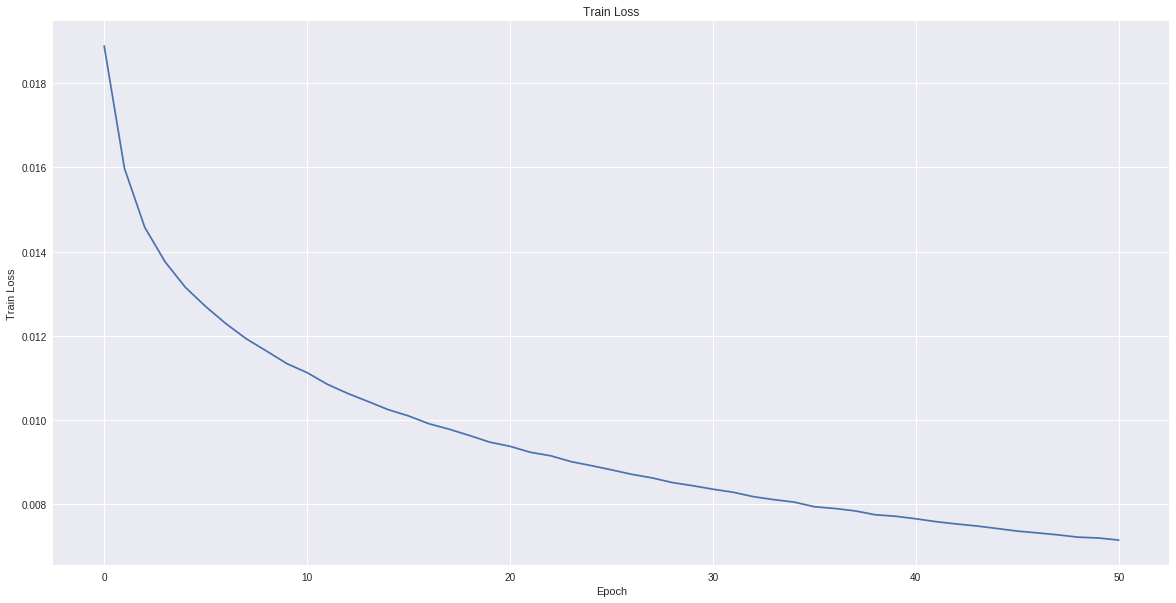

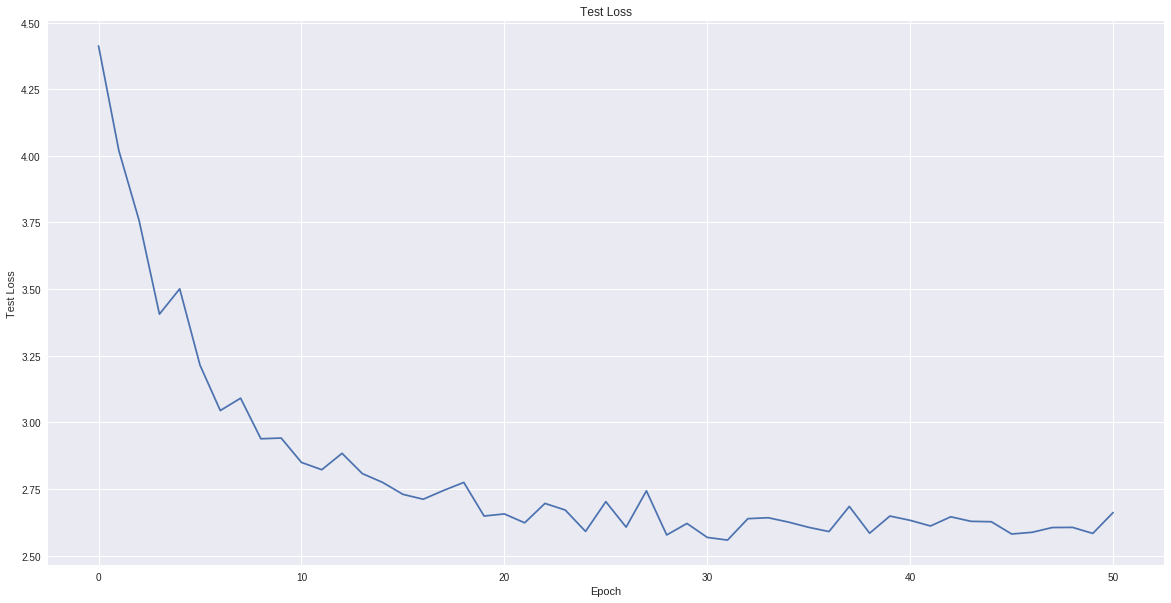

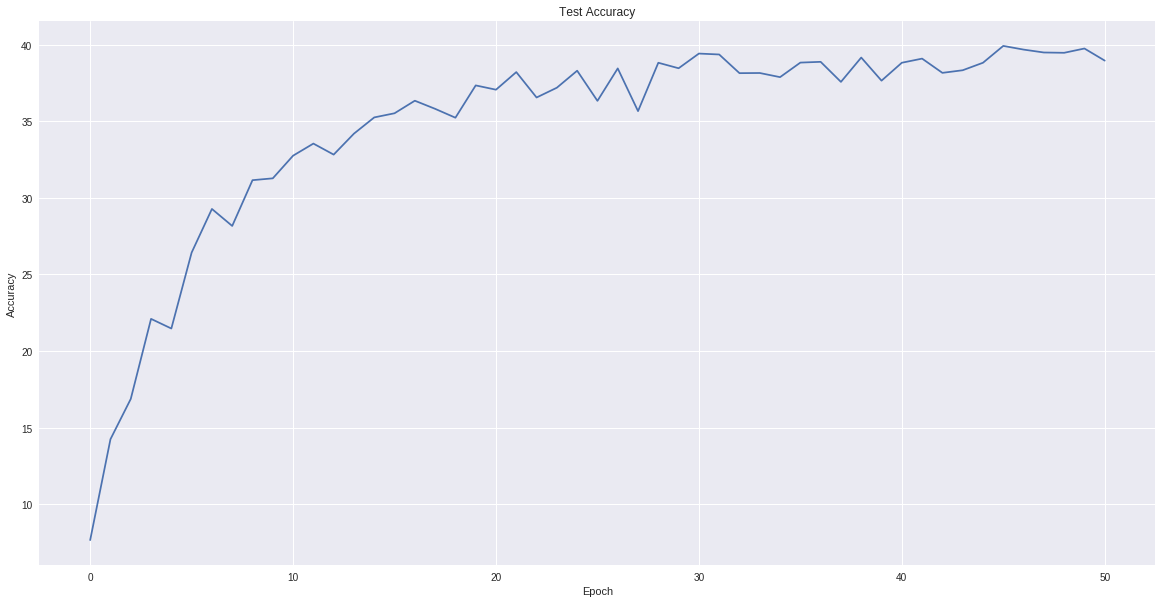

test accuracy:  38.97
Wed Oct 31 23:35:23 2018 Train Epoch: 51 [0/100000 (0%)]	Loss: 1.737670
Wed Oct 31 23:35:53 2018 Train Epoch: 51 [25600/100000 (26%)]	Loss: 1.784131
Wed Oct 31 23:36:24 2018 Train Epoch: 51 [51200/100000 (51%)]	Loss: 1.938168
Wed Oct 31 23:36:54 2018 Train Epoch: 51 [76800/100000 (77%)]	Loss: 1.769551

Test set: Average loss: 2.7055, Accuracy: 3703/10000 (37%)

test accuracy:  37.03
Wed Oct 31 23:37:36 2018 Train Epoch: 52 [0/100000 (0%)]	Loss: 1.839831
Wed Oct 31 23:38:07 2018 Train Epoch: 52 [25600/100000 (26%)]	Loss: 1.829015
Wed Oct 31 23:38:37 2018 Train Epoch: 52 [51200/100000 (51%)]	Loss: 1.849782
Wed Oct 31 23:39:08 2018 Train Epoch: 52 [76800/100000 (77%)]	Loss: 1.929090

Test set: Average loss: 2.6165, Accuracy: 3893/10000 (39%)

test accuracy:  38.93
Wed Oct 31 23:39:50 2018 Train Epoch: 53 [0/100000 (0%)]	Loss: 1.820909
Wed Oct 31 23:40:21 2018 Train Epoch: 53 [25600/100000 (26%)]	Loss: 1.603759
Wed Oct 31 23:40:51 2018 Train Epoch: 53 [51200/100000 (5

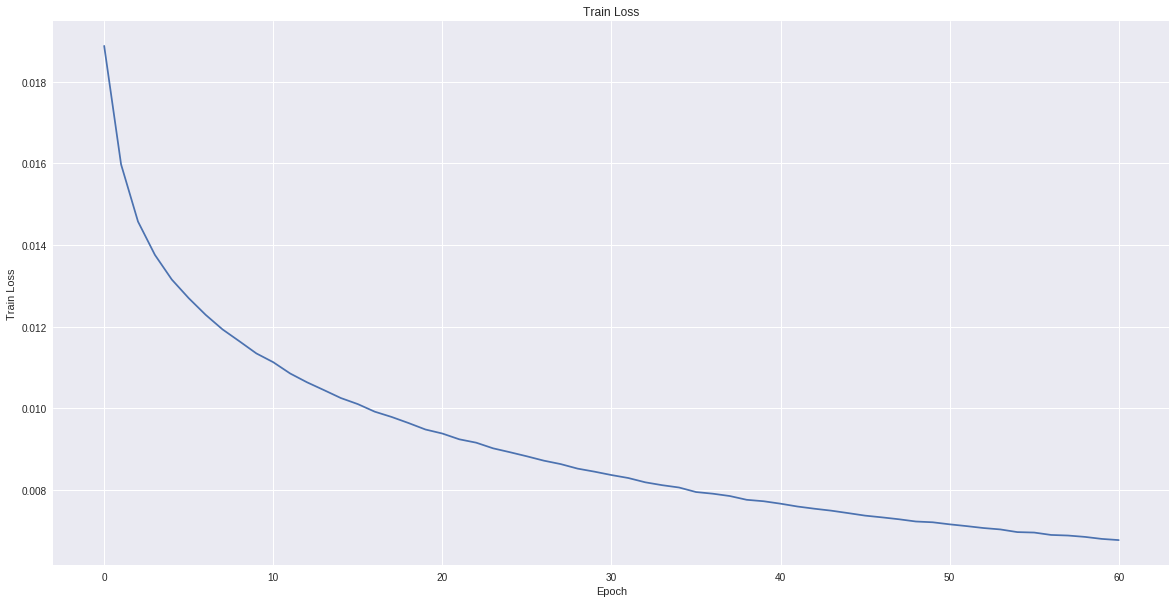

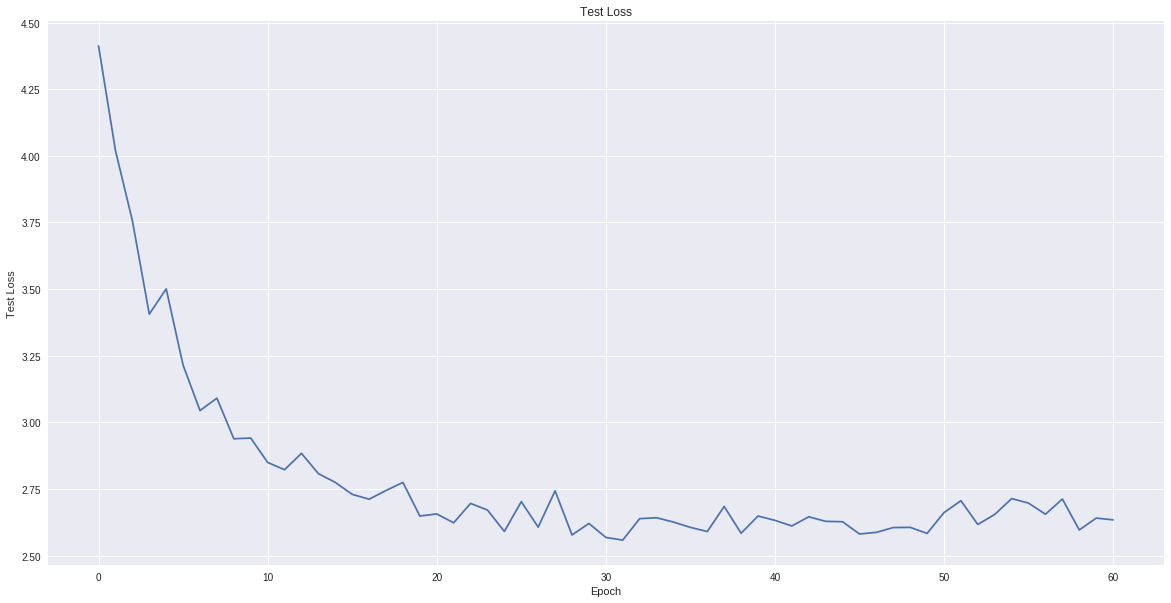

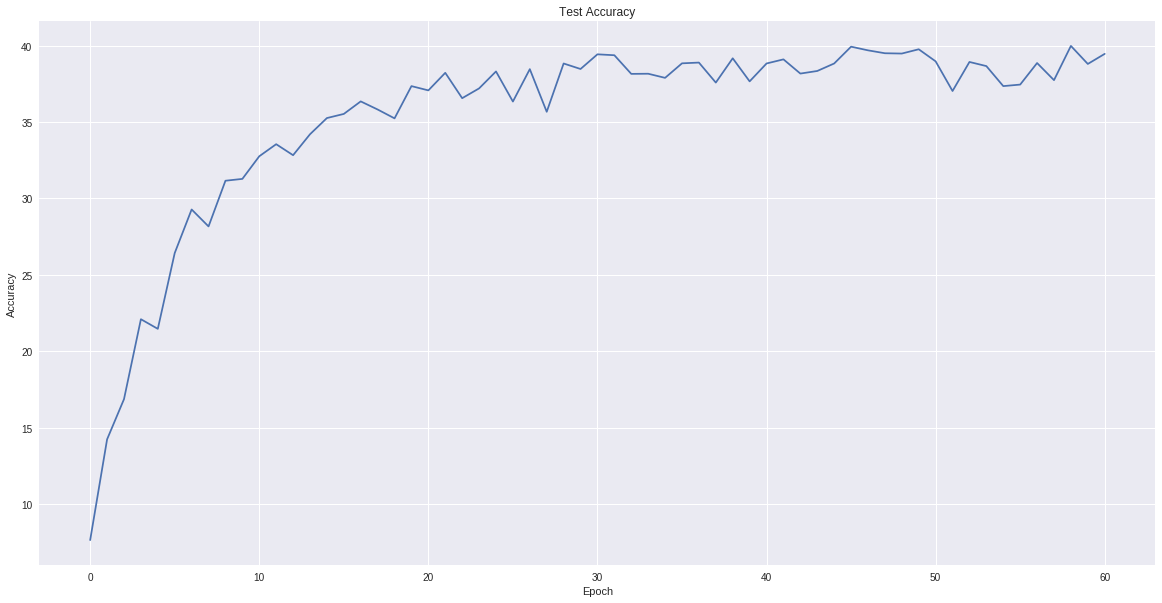

test accuracy:  39.46
Wed Oct 31 23:57:44 2018 Train Epoch: 61 [0/100000 (0%)]	Loss: 1.453463
Wed Oct 31 23:58:15 2018 Train Epoch: 61 [25600/100000 (26%)]	Loss: 1.532330
Wed Oct 31 23:58:45 2018 Train Epoch: 61 [51200/100000 (51%)]	Loss: 1.605489
Wed Oct 31 23:59:16 2018 Train Epoch: 61 [76800/100000 (77%)]	Loss: 1.787663

Test set: Average loss: 2.6188, Accuracy: 3890/10000 (39%)

test accuracy:  38.9
Wed Oct 31 23:59:59 2018 Train Epoch: 62 [0/100000 (0%)]	Loss: 1.537539
Thu Nov  1 00:00:30 2018 Train Epoch: 62 [25600/100000 (26%)]	Loss: 1.793689
Thu Nov  1 00:01:00 2018 Train Epoch: 62 [51200/100000 (51%)]	Loss: 1.963036
Thu Nov  1 00:01:31 2018 Train Epoch: 62 [76800/100000 (77%)]	Loss: 1.480093

Test set: Average loss: 2.6479, Accuracy: 3895/10000 (39%)

test accuracy:  38.95
Thu Nov  1 00:02:13 2018 Train Epoch: 63 [0/100000 (0%)]	Loss: 1.400562
Thu Nov  1 00:02:44 2018 Train Epoch: 63 [25600/100000 (26%)]	Loss: 1.571167
Thu Nov  1 00:03:14 2018 Train Epoch: 63 [51200/100000 (51

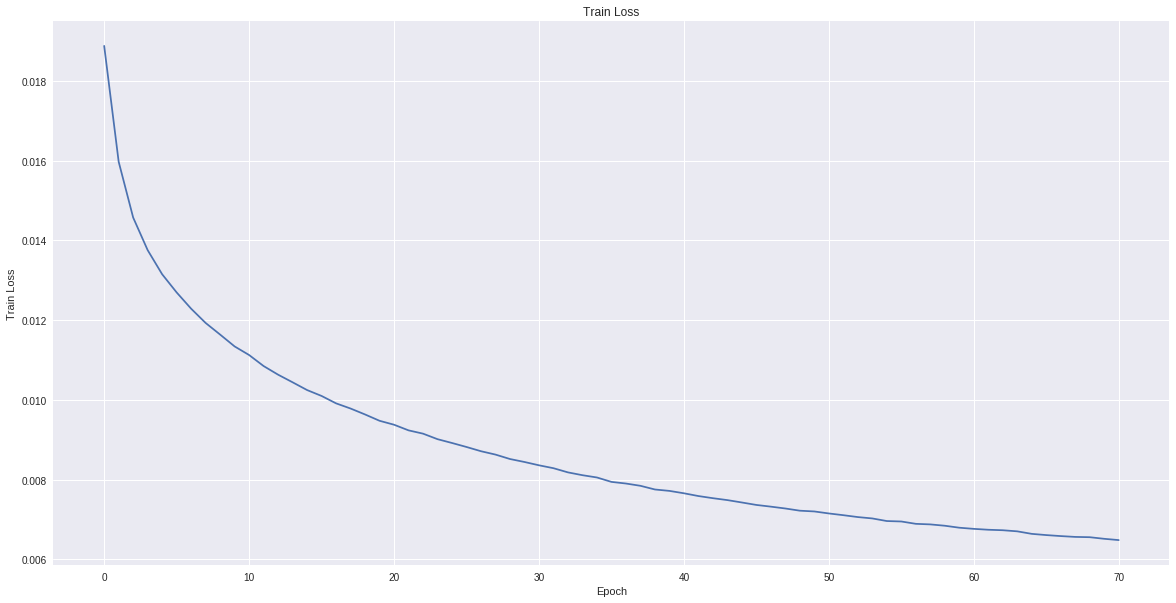

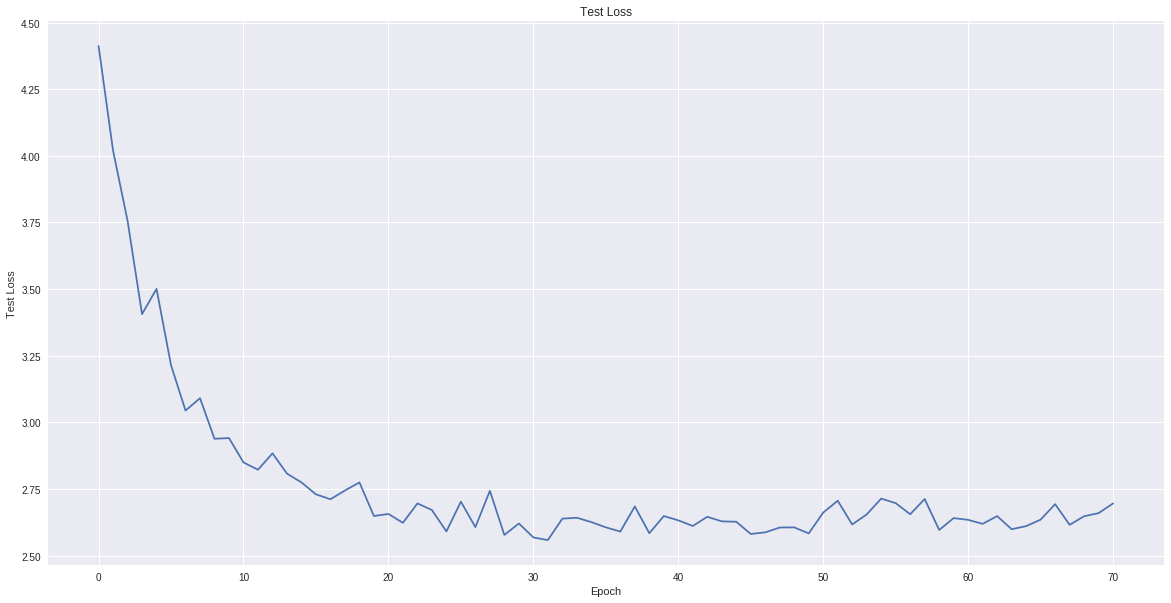

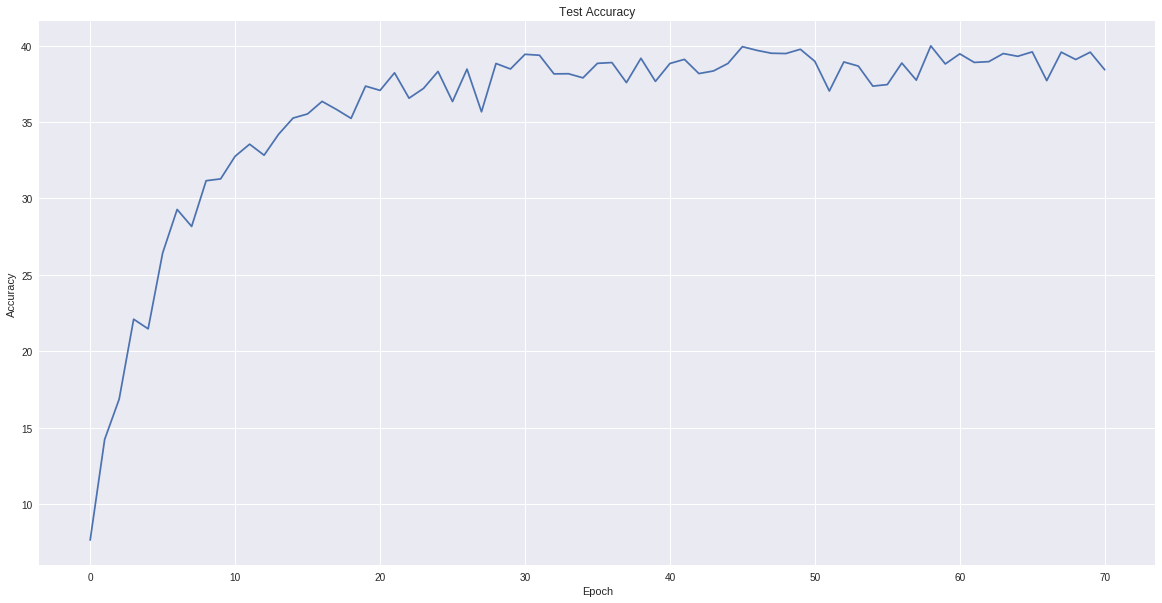

test accuracy:  38.42
Thu Nov  1 00:20:08 2018 Train Epoch: 71 [0/100000 (0%)]	Loss: 1.450845
Thu Nov  1 00:20:39 2018 Train Epoch: 71 [25600/100000 (26%)]	Loss: 1.570308


Process Process-953:
Process Process-954:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/connecti

Interrupted
Saved /gdrive/My Drive/colab_files/homework1/tiny_imagenet/checkpoints/071.pt



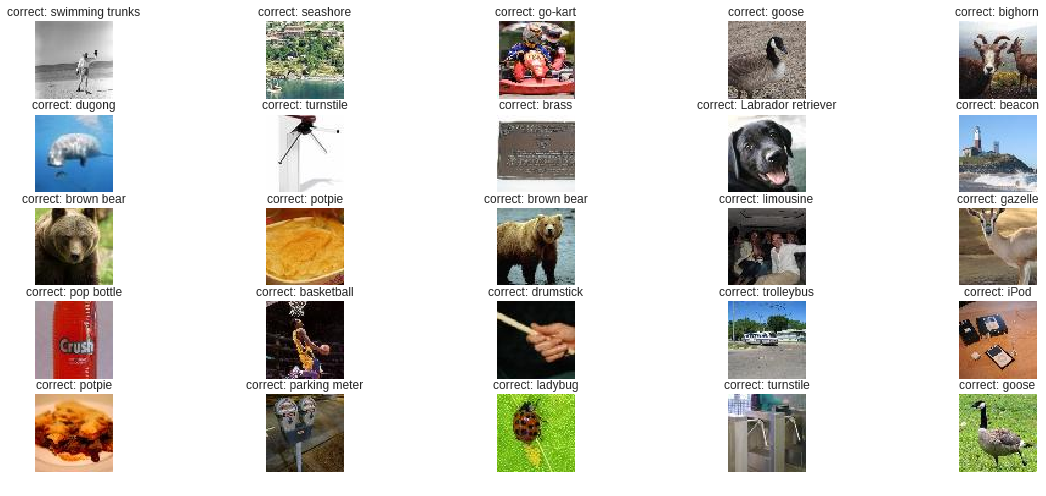

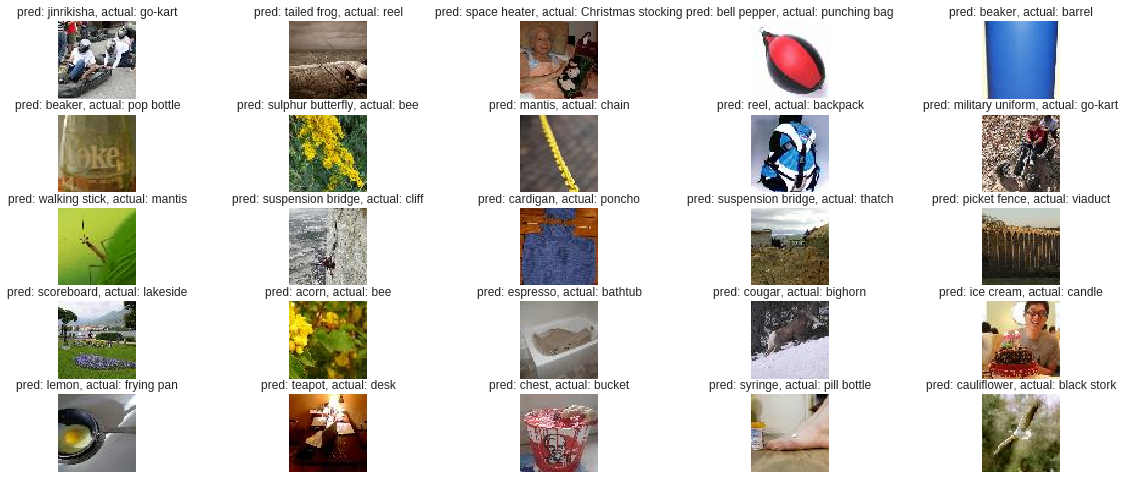

In [24]:
# Play around with these constants, you may find a better setting.
BATCH_SIZE = 256 # Batch size 128 now instead of 256, all results below are 256
# batch size 128 LR 0.01 36% 200 epochs

# new model 7 kernel too, 35% peak at 153 epochs
TEST_BATCH_SIZE = 10
EPOCHS = 200
LEARNING_RATE = 0.01 # 0.001 Epoch 72: 29%, 0.1 Epoch 200 Loss 38% LR 0.01 Epoch 104 33%
# new model Epoch: 70ish Peak at 35% new model 0.1 37% best of 200 epocs 
MOMENTUM = 0.9
USE_CUDA = True
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.0005
LOG_PATH = DATA_PATH + 'log.pkl'
CHECKPOINT_PATH = BASE_PATH + 'tiny_imagenet/test_no_residual/checkpoints'

# Now the actual training code
use_cuda = USE_CUDA and torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

class_names = [line.strip().split(', ') for line in open(DATA_PATH + 'class_names.txt')]
name_to_class = {line[1]: line[0] for line in class_names}
class_names = [line[1] for line in class_names]

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

model = TinyImagenetNet(device)
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
start_epoch = 0 # model.load_last_model(DATA_PATH + 'checkpoints')

# You may want to define another default for your log data depending on how you save it.
log_data = pt_util.read_log(LOG_PATH, [])
epochs = []
train_losses = []
test_losses = []
test_accuracies = []

_, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)
correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
        test_loss, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)
        # TODO define other things to do at the end of each loop like logging and saving the best model.
        test_accuracy = 100. * len(correct_images) / len(test_loader.dataset)
        
        train_losses.append(train_loss)
        test_accuracies.append(test_accuracy)
        test_losses.append(test_loss)
        epochs.append(epoch)
        
        
        model.save_best_model(test_accuracy, CHECKPOINT_PATH + '/%03d.pt' % epoch)
        
        if (epoch % 10 == 0):
          pt_util.plot(epochs, train_losses, "Train Loss", "Epoch", "Train Loss")
          pt_util.plot(epochs, test_losses, "Test Loss", "Epoch", "Test Loss")
          pt_util.plot(epochs, test_accuracies, "Test Accuracy", "Epoch", "Accuracy")
        print('test accuracy: ', test_accuracy)


except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    # Always save the most recent model, but don't delete any existing ones.
    model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
    
    # Show some current correct/incorrect images.
    correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
    error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
    pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
    pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])

# Part 6: ImageNet!
ImageNet is the big granddaddy of supervised vision datasets. It's the dataset that got the whole deep learning train running. We thought it would be fun for you guys to try your hand at it.

A few notes:
- Downloading ImageNet should take about 7 minutues. Extracting should take another 7 minutes. So run this code, then go have a coffee or whatever.
- The data will be removed after 24 hours or so. That's just how Colab works. Each time you reset the environment, you will also have to redownload ImageNet. 
    - I would recommend against storing it on your on Google Drive though as that is way slower to read during training.
    - Through extensive testing, we have found that the fastest way to get the data is the code we provide (faster than saving to google drive, uploading by hand, etc.) 
- Reading images directly with PIL seems to have issues on Colab. Instead try cv2.imread.
    - cv2.imread returns images in bgr order. To go from bgr -> rgb, use    `im = im[:, :, ::-1]`
- The images are provided such that the minimum side length is at least 128 unless the original image was too small for it to be shrunk.
    - transforms.Resize will be your friend
- It seams you cannot use a batch size > 64 x 128 x 128 x 3 while still using multiprocessing due to Colab limitations. You can use larger batches if you set num_workers = 0, but it will be much slower.
- This dataset has 1000 classes, whereas Tiny ImageNet only had 200.
- You will probably want to save your results more than once every epoch since Colab may spurriously shut down your session.
- We know this takes a long time to run. Try leaving it overnight. We don't expect you to get state-of-the-art performance.
- `glob.glob` is a good Python function for reading lots of folder/file names, but it does not return a sorted list.




In [9]:
# Downloads and extracts the data
if not os.path.exists('imagenet128'):
    !echo $(date +%x_%r)
    !gsutil cp gs://imagenet-cropped/imagenet128.tar .
    !echo $(date +%x_%r)
    !tar -xf imagenet128.tar
    !echo $(date +%x_%r)
    !ls imagenet128/train | head -4

11/01/2018_03:24:20 AM
Copying gs://imagenet-cropped/imagenet128.tar...
\ [1 files][ 23.7 GiB/ 23.7 GiB]   56.6 MiB/s                                   
Operation completed over 1 objects/23.7 GiB.                                     
11/01/2018_03:31:51 AM
11/01/2018_03:37:32 AM
n01440764
n01443537
n01484850
n01491361


In [0]:
# Sets up synset data. Have a look at what is in these dictionaries as they may help you with debugging.
import json
imagenet_synset_data = json.load(open('imagenet128/imagenet_synsets.json'))
synset_id_to_cls = {val['id']: int(key) for key, val in imagenet_synset_data.items()}

In [0]:
# Data loader
class ImageFolderLoader(torch.utils.data.Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        self.file_list = []
        for label_folder in synset_id_to_cls.keys():
          label = synset_id_to_cls[label_folder]
          file_folder = os.path.join(folder, str(label_folder))
          for path in os.listdir(file_folder):
            self.file_list.append((file_folder + "/" + path, label))
        
        

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        data_path, label = self.file_list[idx]
        im = cv2.imread(data_path)
        im[:, :, ::-1]
        #?
        if self.transform is not None:
          im = self.transform(im)
        
        im = torch.Tensor(im)
        label = torch.Tensor([label]).long()
        return im, label


In [12]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

data_train = ImageFolderLoader('imagenet128/train', transform=train_transforms)
print(len(data_train))
assert(len(data_train) == 1281167)
data_test = ImageFolderLoader('imagenet128/val', transform=test_transforms)
assert(len(data_test) == 50000)

1281167


In [0]:
class FullImagenetNet(TinyImagenetNet):
    def __init__(self, device):
          super(FullImagenetNet, self).__init__(device)
          # TODO define the layers
          self.conv0 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
          self.conv1 = Block(32, 12, device)
          self.conv2 = Block(36, 12, device)
          self.conv3 = Block(36, 24, device)
          self.conv4 = Block(72, 24, device)
          self.conv5 = Block(72, 72, device)
          self.fc1 = nn.Linear(3456, 3456) 
          self.fc2 = nn.Linear(3456, 1000) # 200 classes
          self.best_acc = 0

    def forward(self, x):
        # TODO define the forward pass
        batch = x.shape[0]
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = F.dropout(x, training=self.training)
        x = self.conv4(x)
        x = self.conv5(x)
        x = F.dropout(x, training=self.training)
        x = x.view(batch, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
#     def __init__(self, device):
#         super(TinyImagenetNet, self).__init__()
#         # TODO define the layers
#         self.conv1 = Block(3, 64, device)
#         self.conv2 = Block(64 * 3, 64, device)
#         self.conv3 = Block(64 * 3, 128, device)
#         self.conv4 = Block(128 * 3, 128, device)
#         self.conv5 = Block(128 * 3, 256, device)
#         self.conv6 = Block(256 * 3, 256, device)
#         self.conv3_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(3072, 1000) # 1000 classes
#         self.best_acc = 0

#     def forward(self, x):
#         # TODO define the forward pass
#         batch = x.shape[0]
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = F.dropout(x, training=self.training)
#         x = self.conv4(x)
#         x = self.conv5(x)
#         x = self.conv6(x)
#         x = x.view(batch, -1)
#         x = F.dropout(x, training=self.training)
#         x = self.fc1(x)
  #         return x

Using device cuda
num cpus: 2
Restoring:
conv0.weight -> 	torch.Size([32, 3, 3, 3]) = 0MB
conv0.bias -> 	torch.Size([32]) = 0MB
conv1.conv3.weight -> 	torch.Size([12, 32, 5, 5]) = 0MB
conv1.conv3.bias -> 	torch.Size([12]) = 0MB
conv1.conv2.weight -> 	torch.Size([12, 32, 3, 3]) = 0MB
conv1.conv2.bias -> 	torch.Size([12]) = 0MB
conv1.conv1.weight -> 	torch.Size([12, 32, 1, 1]) = 0MB
conv1.conv1.bias -> 	torch.Size([12]) = 0MB
conv1.bn.weight -> 	torch.Size([36]) = 0MB
conv1.bn.bias -> 	torch.Size([36]) = 0MB
conv1.bn.running_mean -> 	torch.Size([36]) = 0MB
conv1.bn.running_var -> 	torch.Size([36]) = 0MB
conv1.bn.num_batches_tracked -> 	torch.Size([]) = 0MB
conv2.conv3.weight -> 	torch.Size([12, 36, 5, 5]) = 0MB
conv2.conv3.bias -> 	torch.Size([12]) = 0MB
conv2.conv2.weight -> 	torch.Size([12, 36, 3, 3]) = 0MB
conv2.conv2.bias -> 	torch.Size([12]) = 0MB
conv2.conv1.weight -> 	torch.Size([12, 36, 1, 1]) = 0MB
conv2.conv1.bias -> 	torch.Size([12]) = 0MB
conv2.bn.weight -> 	torch.Size([36]) 

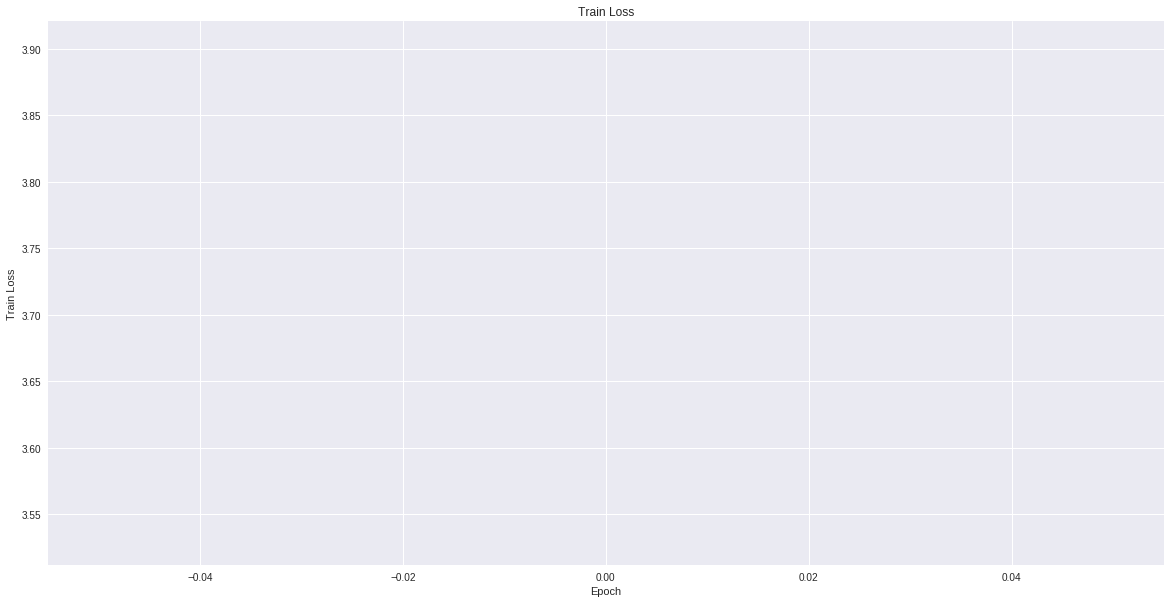

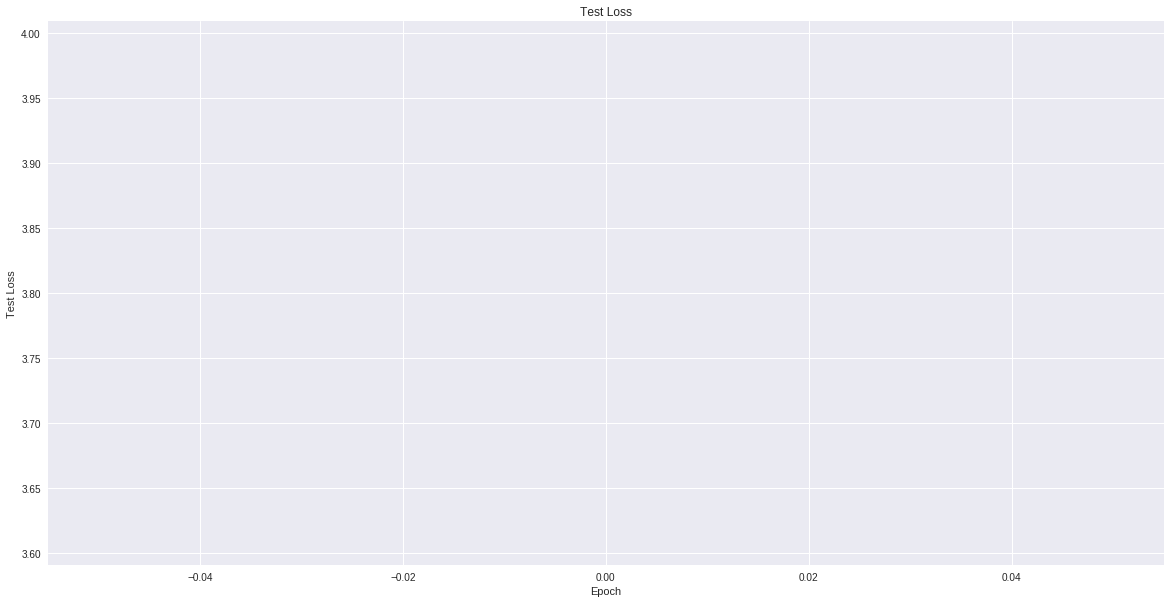

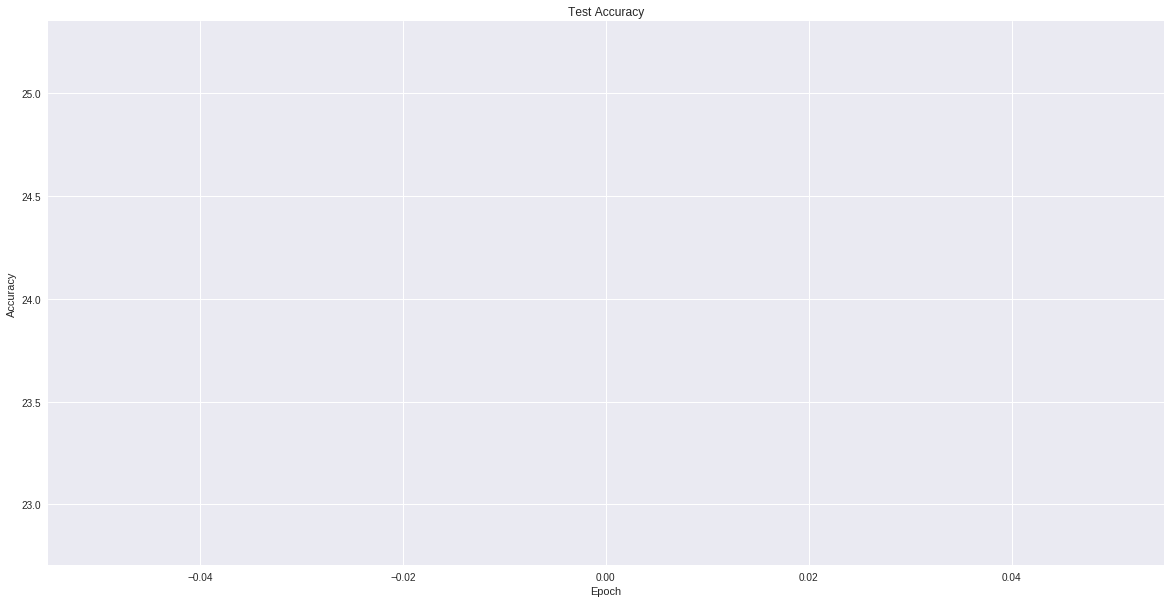

Saved /gdrive/My Drive/colab_files/homework1/imagenet_full/test_2_final/checkpoints/000.pt

Thu Nov  1 07:25:04 2018 Train Epoch: 1 [0/1281167 (0%)]	Loss: 3.454397
Thu Nov  1 07:25:33 2018 Train Epoch: 1 [6400/1281167 (0%)]	Loss: 3.257153
Thu Nov  1 07:26:01 2018 Train Epoch: 1 [12800/1281167 (1%)]	Loss: 3.329135
Thu Nov  1 07:26:29 2018 Train Epoch: 1 [19200/1281167 (1%)]	Loss: 3.791497
Thu Nov  1 07:26:58 2018 Train Epoch: 1 [25600/1281167 (2%)]	Loss: 3.611782
Thu Nov  1 07:27:26 2018 Train Epoch: 1 [32000/1281167 (2%)]	Loss: 3.309078
Thu Nov  1 07:27:54 2018 Train Epoch: 1 [38400/1281167 (3%)]	Loss: 3.230230
Thu Nov  1 07:28:23 2018 Train Epoch: 1 [44800/1281167 (3%)]	Loss: 3.112608
Thu Nov  1 07:28:51 2018 Train Epoch: 1 [51200/1281167 (4%)]	Loss: 3.950617
Thu Nov  1 07:29:19 2018 Train Epoch: 1 [57600/1281167 (4%)]	Loss: 3.759874
Thu Nov  1 07:29:48 2018 Train Epoch: 1 [64000/1281167 (5%)]	Loss: 3.309290
Thu Nov  1 07:30:16 2018 Train Epoch: 1 [70400/1281167 (5%)]	Loss: 3.549928
T

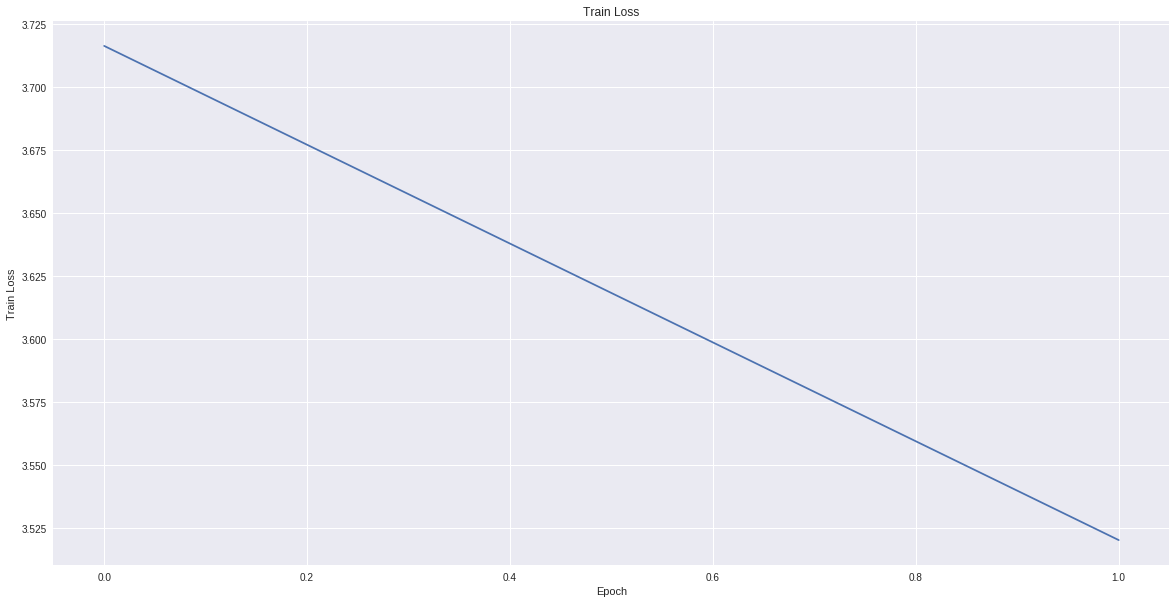

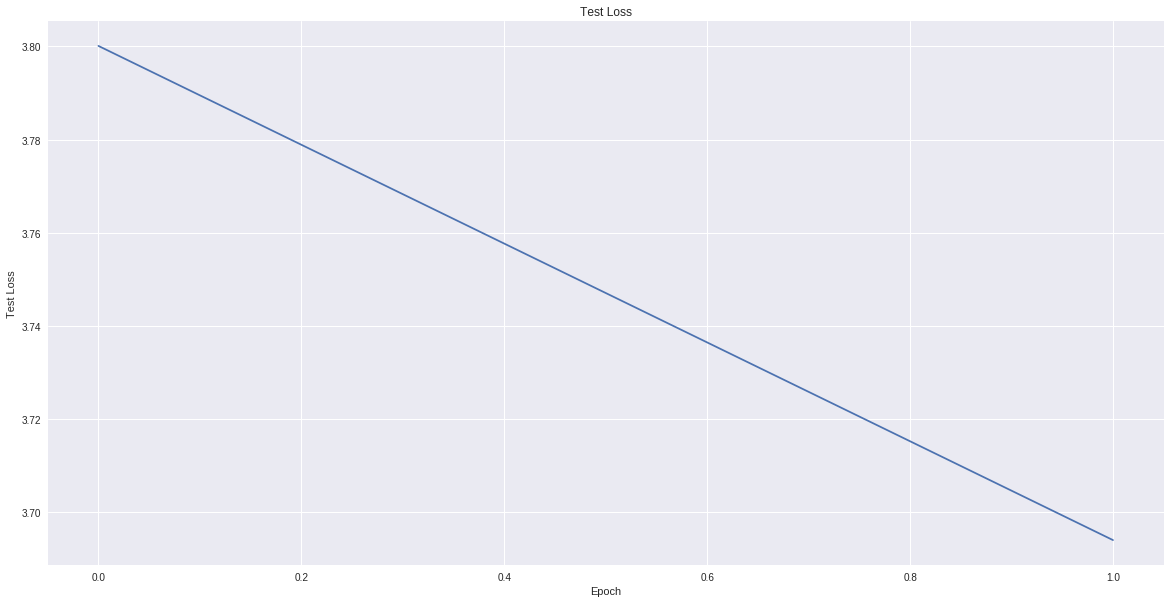

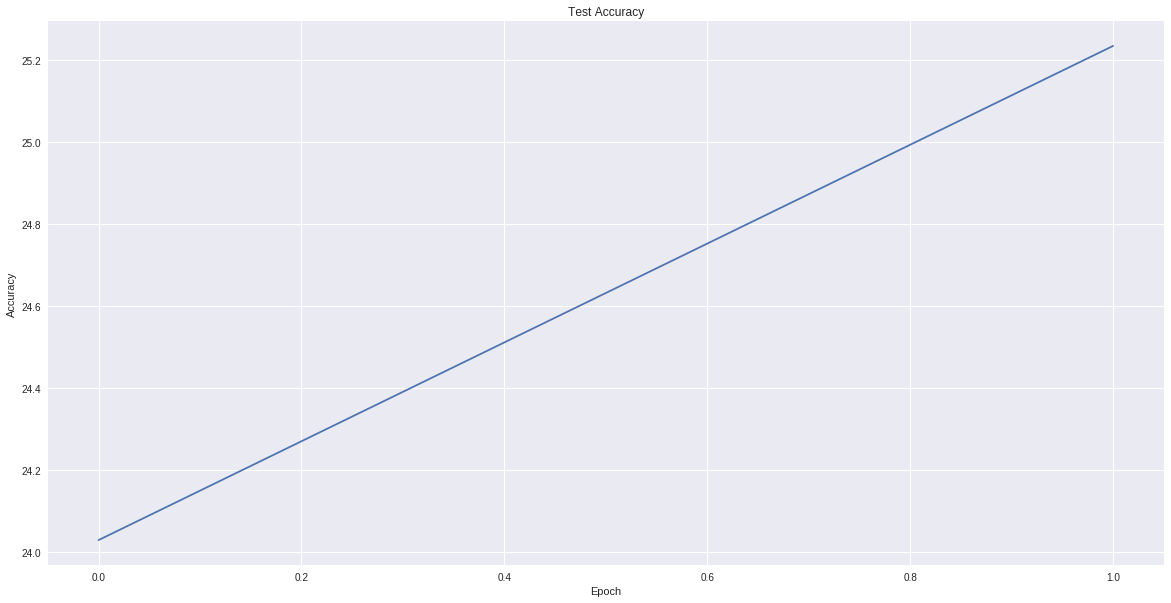

Saved /gdrive/My Drive/colab_files/homework1/imagenet_full/test_2_final/checkpoints/001.pt

Thu Nov  1 09:02:38 2018 Train Epoch: 2 [0/1281167 (0%)]	Loss: 2.973853
Thu Nov  1 09:03:06 2018 Train Epoch: 2 [6400/1281167 (0%)]	Loss: 3.731541
Thu Nov  1 09:03:34 2018 Train Epoch: 2 [12800/1281167 (1%)]	Loss: 3.402411
Thu Nov  1 09:04:03 2018 Train Epoch: 2 [19200/1281167 (1%)]	Loss: 3.605744
Thu Nov  1 09:04:31 2018 Train Epoch: 2 [25600/1281167 (2%)]	Loss: 3.698778
Thu Nov  1 09:04:59 2018 Train Epoch: 2 [32000/1281167 (2%)]	Loss: 2.941721
Thu Nov  1 09:05:28 2018 Train Epoch: 2 [38400/1281167 (3%)]	Loss: 2.704513
Thu Nov  1 09:05:56 2018 Train Epoch: 2 [44800/1281167 (3%)]	Loss: 3.100973
Thu Nov  1 09:06:24 2018 Train Epoch: 2 [51200/1281167 (4%)]	Loss: 3.210789
Thu Nov  1 09:06:53 2018 Train Epoch: 2 [57600/1281167 (4%)]	Loss: 2.438910
Thu Nov  1 09:07:21 2018 Train Epoch: 2 [64000/1281167 (5%)]	Loss: 3.413985
Thu Nov  1 09:07:50 2018 Train Epoch: 2 [70400/1281167 (5%)]	Loss: 3.410035
T

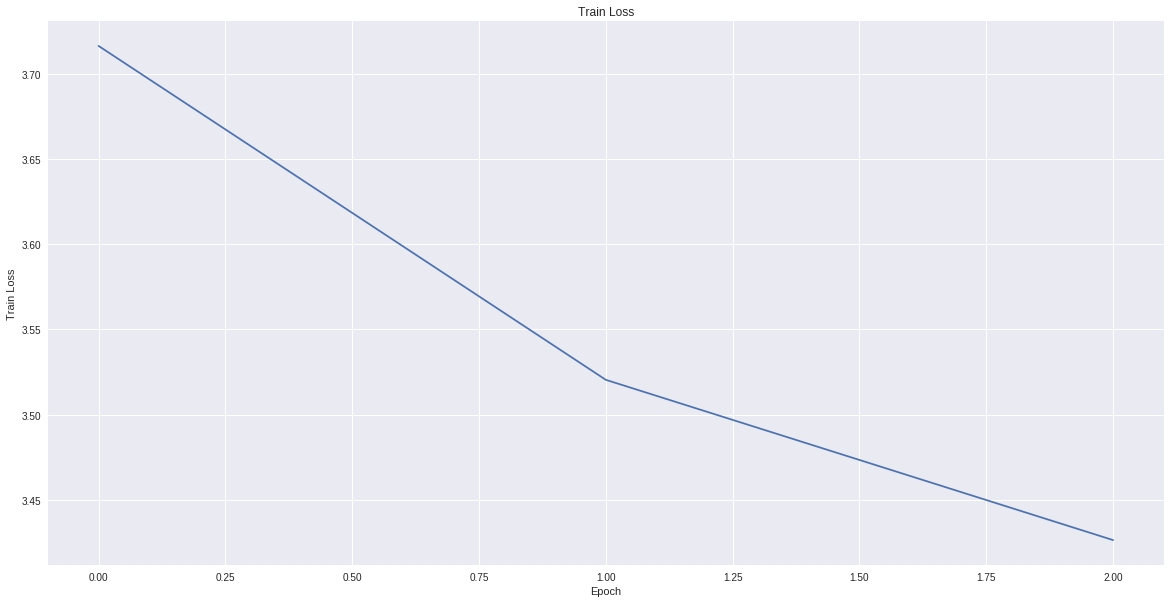

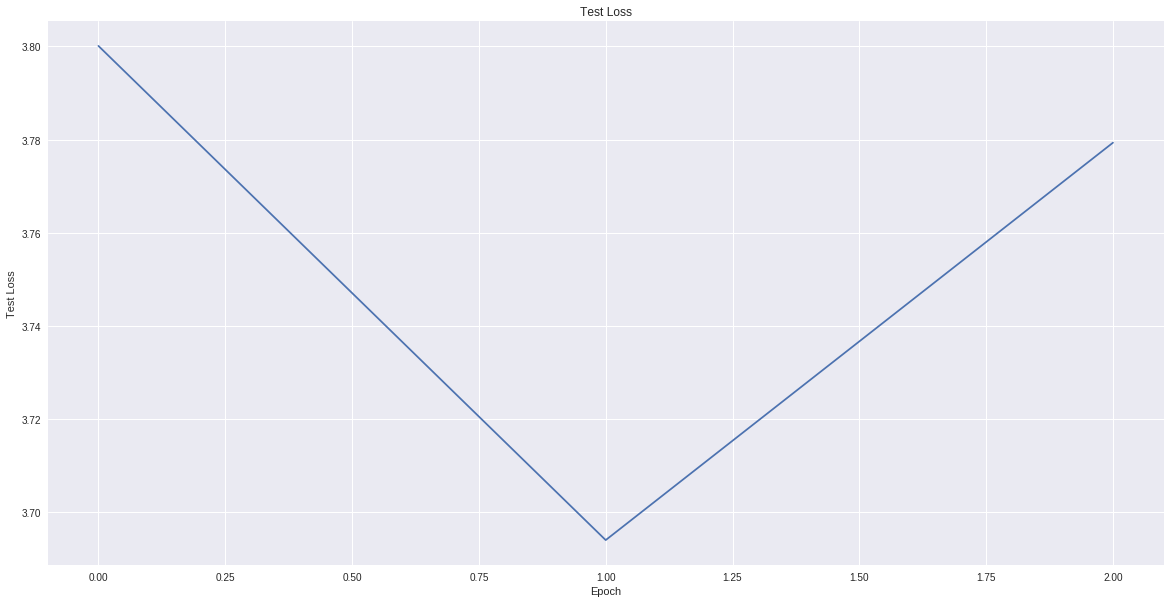

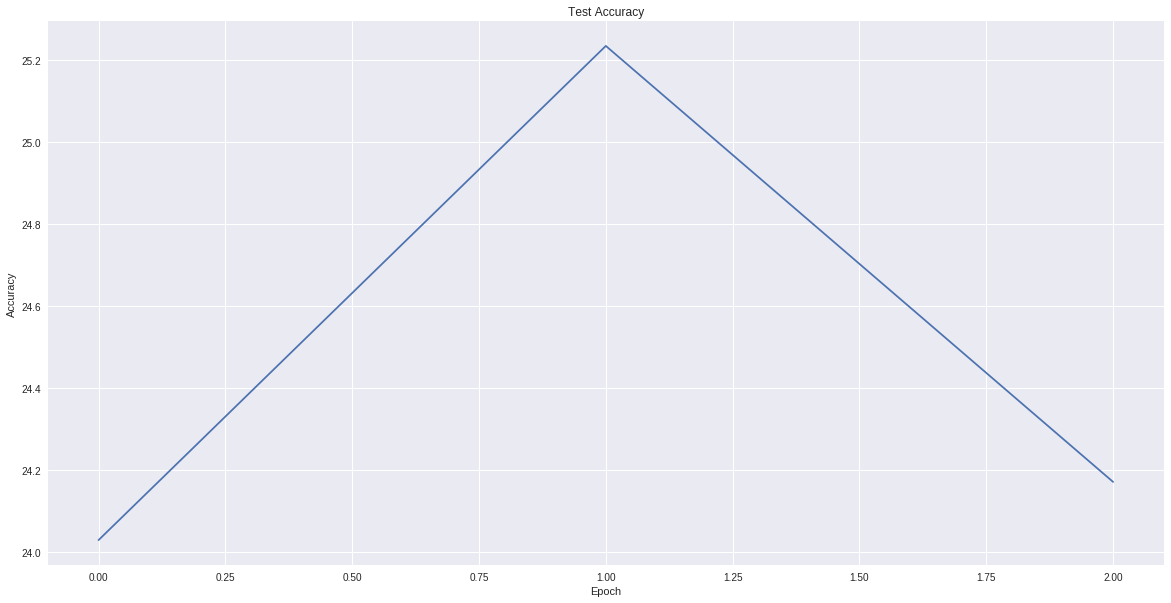

Thu Nov  1 10:40:10 2018 Train Epoch: 3 [0/1281167 (0%)]	Loss: 3.811386
Thu Nov  1 10:40:39 2018 Train Epoch: 3 [6400/1281167 (0%)]	Loss: 3.060866
Thu Nov  1 10:41:07 2018 Train Epoch: 3 [12800/1281167 (1%)]	Loss: 3.327479
Thu Nov  1 10:41:35 2018 Train Epoch: 3 [19200/1281167 (1%)]	Loss: 3.253863
Thu Nov  1 10:42:04 2018 Train Epoch: 3 [25600/1281167 (2%)]	Loss: 2.964428
Thu Nov  1 10:42:32 2018 Train Epoch: 3 [32000/1281167 (2%)]	Loss: 3.158802
Thu Nov  1 10:43:00 2018 Train Epoch: 3 [38400/1281167 (3%)]	Loss: 2.809681
Thu Nov  1 10:43:29 2018 Train Epoch: 3 [44800/1281167 (3%)]	Loss: 2.853528
Thu Nov  1 10:43:57 2018 Train Epoch: 3 [51200/1281167 (4%)]	Loss: 3.363444
Thu Nov  1 10:44:26 2018 Train Epoch: 3 [57600/1281167 (4%)]	Loss: 3.400769
Thu Nov  1 10:44:54 2018 Train Epoch: 3 [64000/1281167 (5%)]	Loss: 3.335238
Thu Nov  1 10:45:22 2018 Train Epoch: 3 [70400/1281167 (5%)]	Loss: 3.487191
Thu Nov  1 10:45:51 2018 Train Epoch: 3 [76800/1281167 (6%)]	Loss: 3.700142
Thu Nov  1 10:46:

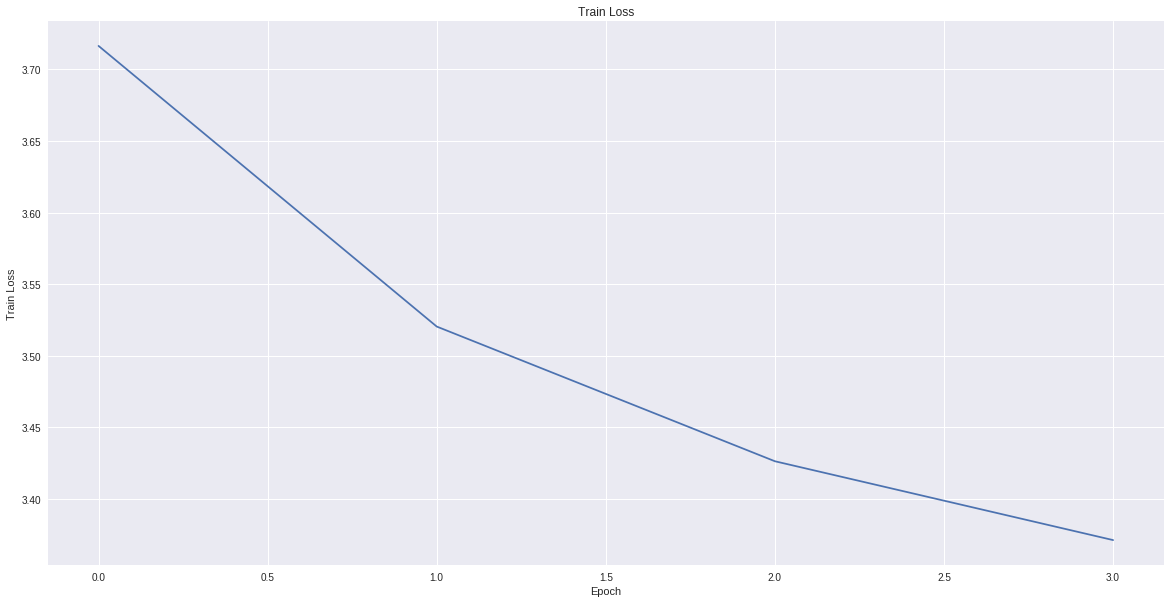

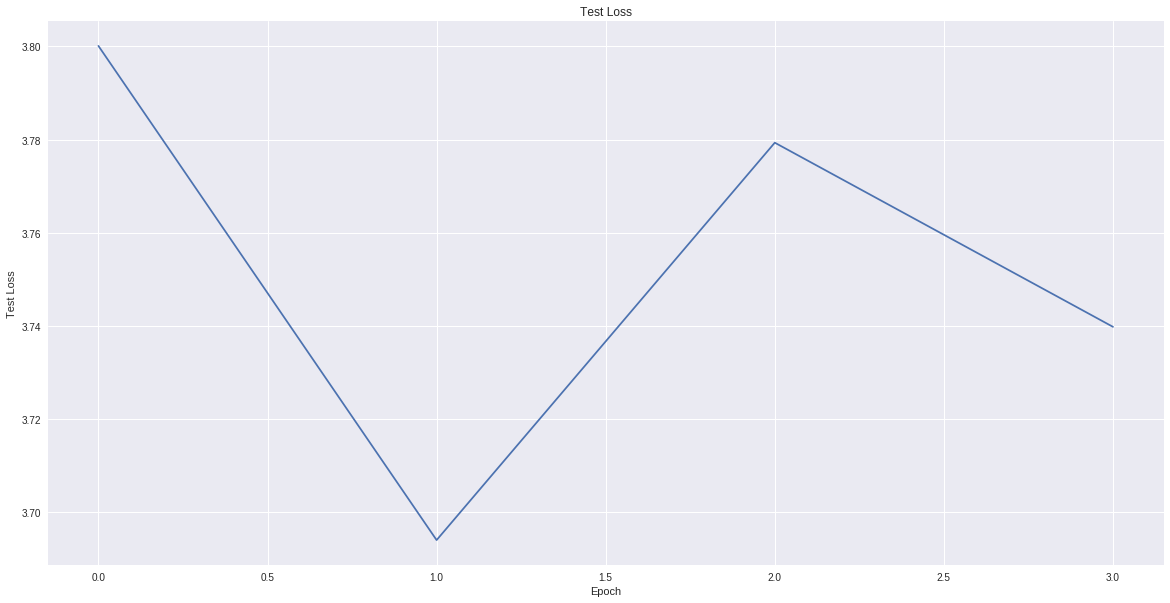

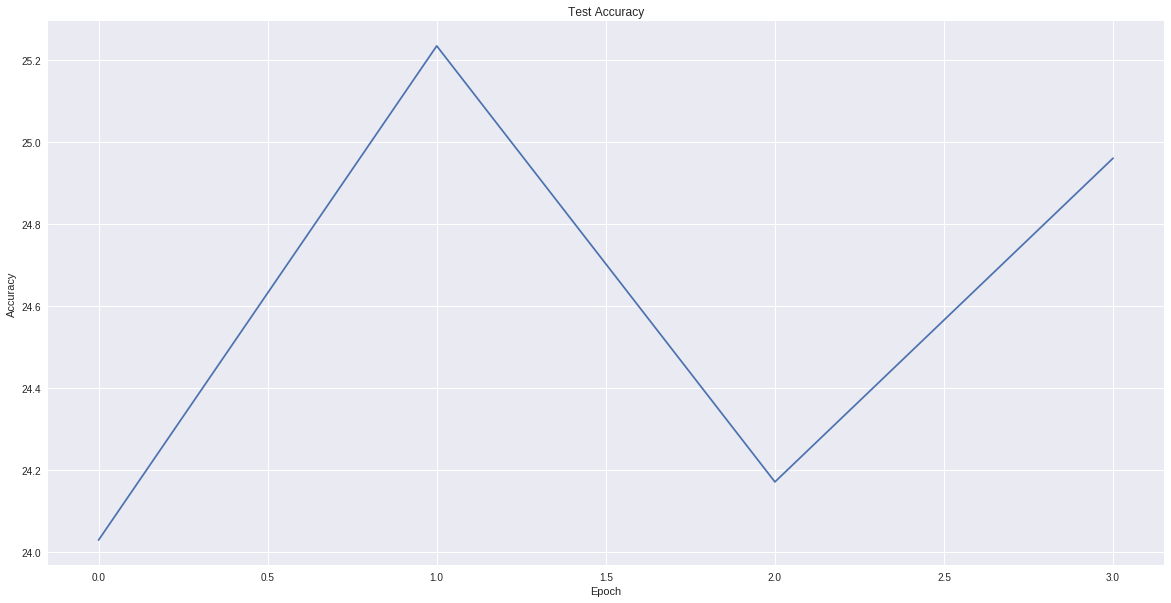

Thu Nov  1 12:17:44 2018 Train Epoch: 4 [0/1281167 (0%)]	Loss: 2.889886
Thu Nov  1 12:18:12 2018 Train Epoch: 4 [6400/1281167 (0%)]	Loss: 2.780484
Thu Nov  1 12:18:41 2018 Train Epoch: 4 [12800/1281167 (1%)]	Loss: 3.040723


In [0]:
BATCH_SIZE = 64
TEST_BATCH_SIZE = 50
EPOCHS = 200
LEARNING_RATE = 0.01
MOMENTUM = 0.9
USE_CUDA = True
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.0005
CHECKPOINT_PATH = BASE_PATH + 'imagenet_full/test_2_final/checkpoints'
LOG_PATH = BASE_PATH + 'imagenet_full/test_2_final/' + 'log.pkl'

use_cuda = USE_CUDA and torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}


class_names = sorted([(int(key), val['label'].split(',')[0]) for key, val in imagenet_synset_data.items()])
name_to_class = {line[1]: line[0] for line in class_names}
class_names = [line[1] for line in class_names]

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

epochs = []
train_losses = []
test_losses = []
test_accuracies = []

model = FullImagenetNet(device).to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
start_epoch = model.load_last_model(CHECKPOINT_PATH)
# test(model, device, test_loader, False, 100)

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
        print('testing')
        test_accuracy, test_loss = test(model, device, test_loader, False, 100, True)
        # correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True, 1000)
        # TODO define other things to do at the end of each loop like logging and saving the best model.
        # test_accuracy = 100. * len(correct_images) / len(test_loader.dataset)
        print('test acc: {}'.format(test_accuracy))
        
        train_losses.append(train_loss)
        test_accuracies.append(test_accuracy)
        test_losses.append(test_loss)
        epochs.append(epoch)
        pt_util.plot(epochs, train_losses, "Train Loss", "Epoch", "Train Loss")
        pt_util.plot(epochs, test_losses, "Test Loss", "Epoch", "Test Loss")
        pt_util.plot(epochs, test_accuracies, "Test Accuracy", "Epoch", "Accuracy")
        model.save_best_model(test_accuracy, CHECKPOINT_PATH + '/%03d.pt' % epoch)
        # model.save_model(CHECKPOINT_PATH + '/%03d.pt' % epoch, 0)


except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    model.save_model(CHECKPOINT_PATH + '/%03d.pt' % epoch, 0)

# Part 7: Short answer questions
Please answer these questions, and put the answers in a file called homework1_python.pdf in your repository.

# Tiny ImageNet
1. What design that you tried worked the best? This includes things like network design, learning rate, batch size, number of epochs, and other optimization parameters, data augmentation etc. What was the final train loss? Test loss? Test Accuracy? Provide the plots for train loss, test loss, and test accuracy.
2. What design worked the worst (but still performed better than random chance)? Provide all the same information as question 1.
3. Why do you think the best one worked well and the worst one worked poorly.


# Full ImageNet
1. What design that you tried worked the best? How many epochs were you able to run it for? Provide the same information from Tiny ImageNet question 1.
2. Were you able to use larger/deeper networks on Full ImageNet than you used on Tiny ImageNet and increase accuracy? If so, why? If not, why not?
3. The real ImageNet dataset has significantly larger images. How would you change your network design if the images were twice as large? How about smaller than Tiny ImageNet (32x32)? How do you think your accuracy would change? This is open-ended, but we want a more thought-out answer than "I'd resize the images" or "I'd do a larger pooling stride." You don't have to write code to test your hypothesis.

Additionally, download your .ipynb and put it in your repository and name it homework1_colab.ipynb

